In [10]:
import torch
from models import IVAE

import os
import itertools
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import wandb

from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

from statsmodels.stats.multitest import multipletests

# Choose device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pictures for the slides

In [3]:
project_path = "arman-beykmohammadi/IVAE - Sweep - LS"
api = wandb.Api()
runs = api.runs(project_path)
finished_runs = [run for run in runs if run.state == "finished"]

# Container for run info: (run, avg_loss_rec, coeff_kl)
run_data = []

# Loop over all runs in the project
for run in finished_runs:
    # Assume each run logs per-fold loss_rec as, e.g., "fold_0_loss_rec", ..., "fold_4_loss_rec"
    pictures = []
    for i in range(1, 6):
        key = f"Fold {i}-reconstructed"
        # Make sure the key exists in the run summary (or history, depending on how you log it)
        if key in run.summary:
            pictures.append(run.summary[key])
        else:
            print(
                f"Warning: {key} not found in run {run.name}. Skipping this run.")
            pictures = []
            break  # Skip this run if not all folds are available

    if not pictures:
        continue  # skip run if we didn't get all 5 fold losses

    # Get the coeff_kl from the run configuration (defaulting to 0 if not present)
    coeff_kl = run.config.get("coeff_kl", 0)

    run_data.append((run.name, pictures))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
run_data[83][1][4].keys()

In [ ]:
run_data[83][1][4]['captions']

In [ ]:
tensors = []
for i in range(len(run_data)):
    for j in range(5):
        tensors.append(run_data[i][1][j]['captions'])

In [ ]:
def extract_tensors(list_of_lists):
    extracted_data = []
    # Pattern to extract tensor values
    tensor_pattern = re.compile(r"\[([\d\.\s,]+)\]")

    for sublist in list_of_lists:
        extracted_sublist = []
        for item in sublist:
            match = tensor_pattern.search(item)
            if match:
                numbers = [float(num) for num in match.group(1).split(",")]
                extracted_sublist.append(numbers)
        extracted_data.append(extracted_sublist)

    return np.array(extracted_data)  # Convert to NumPy array


def find_matching_pairs(numerical_data):
    matching_pairs = []
    index_pairs = []

    data_dict = {}
    for i, sublist in enumerate(numerical_data):
        for j, data_point in enumerate(sublist):
            # Second and third values as key
            key = (data_point[1], data_point[2])
            if key in data_dict:
                for prev_i, prev_j in data_dict[key]:
                    if numerical_data[prev_i][prev_j][0] != data_point[0]:
                        matching_pairs.append(
                            (numerical_data[prev_i][prev_j], data_point))
                        index_pairs.append(((prev_i, prev_j), (i, j)))

            if key not in data_dict:
                data_dict[key] = []
            data_dict[key].append((i, j))

    return matching_pairs, index_pairs


numerical_data = extract_tensors(tensors)
matching_pairs, index_pairs = find_matching_pairs(numerical_data)

# Finding the best model

## Loss reconstruction comparision

In [ ]:
project_path = "arman-beykmohammadi/IVAE - Sweep - LS"
api = wandb.Api()
runs = api.runs(project_path)
finished_runs = [run for run in runs if run.state == "finished"]

# Container for run info: (run, avg_loss_rec, coeff_kl)
run_data = []

# Loop over all runs in the project
for run in finished_runs:
    # Assume each run logs per-fold loss_rec as, e.g., "fold_0_loss_rec", ..., "fold_4_loss_rec"
    fold_losses = []
    for i in range(1, 6):
        key = f"train/Fold {i}-loss_rec"
        # Make sure the key exists in the run summary (or history, depending on how you log it)
        if key in run.summary:
            fold_losses.append(run.summary[key])
        else:
            print(
                f"Warning: {key} not found in run {run.name}. Skipping this run.")
            fold_losses = []
            break  # Skip this run if not all folds are available

    if not fold_losses:
        continue  # skip run if we didn't get all 5 fold losses

    # Compute the average reconstruction loss
    avg_loss_rec = sum(fold_losses) / len(fold_losses)

    # Get the coeff_kl from the run configuration (defaulting to 0 if not present)
    coeff_kl = run.config.get("coeff_kl", 0)

    run_data.append((run, avg_loss_rec, coeff_kl))

In [ ]:
if not run_data:
    raise ValueError("No runs with complete fold losses were found.")

# Determine the lowest average reconstruction loss among all runs
min_avg_loss_rec = min(data[1] for data in run_data)
print(f"Minimum average loss_rec across runs: {min_avg_loss_rec}")

# Define a tolerance threshold.
# For example, we can require the avg_loss_rec to be within 5% of the minimum.
tolerance = 1 * min_avg_loss_rec
print(f"Using tolerance of {tolerance}")

# Filter runs that have avg_loss_rec within (min_avg_loss_rec + tolerance)
eligible_runs = [data for data in run_data if data[1]
                 <= min_avg_loss_rec + tolerance]

if not eligible_runs:
    raise ValueError("No eligible runs found within the loss_rec tolerance.")

len(eligible_runs)

In [ ]:
len(run_data)

In [ ]:
coeff_kl_values = [data[2] for data in run_data]
avg_loss_rec_values = [data[1] for data in run_data]
df = pd.DataFrame({"avg_loss_rec": avg_loss_rec_values,
                  "coeff_kl": coeff_kl_values})

# Create a scatter plot for avg_loss_rec vs coeff_kl
plt.figure(figsize=(10, 6))
plt.scatter(df["coeff_kl"], df["avg_loss_rec"], alpha=0.2, color="blue")
plt.xscale("log")  # Set x-axis to logarithmic scale
plt.xlabel("coeff_kl")
plt.ylabel("avg_loss_rec")
plt.title("Scatter plot of avg_loss_rec vs coeff_kl")
# Ensure only unique coeff_kl values are shown
plt.xticks(df["coeff_kl"].unique())
plt.show()

In [ ]:
run1 = [run for run in run_data if run[2] == 0.01]

names = [data[0].name for data in run1]
avg_loss_rec_values = [data[1] for data in run1]
df = pd.DataFrame({"avg_loss_rec": avg_loss_rec_values,
                  "names": names})

# Create a scatter plot for avg_loss_rec vs names
plt.figure(figsize=(10, 6))
plt.scatter(df["avg_loss_rec"], df["names"], alpha=0.2, color="blue")
plt.xlabel("names")
plt.ylabel("avg_loss_rec")
plt.title("Scatter plot of avg_loss_rec vs names")
# Ensure only unique names values are shown
plt.show()

In [ ]:
# From these, select the run with the highest coeff_kl.
best_run, best_avg_loss, best_coeff_kl = min(
    [run for run in run_data if run[2] == 0.01], key=lambda x: x[1])

print("Best run selected:")
print(f"Run Name: {best_run.name}")
print(f"Average loss_rec: {best_avg_loss}")
print(f"coeff_kl: {best_coeff_kl}")

# Questions

### Model choosing and loading

In [3]:
project_path = "arman-beykmohammadi/IVAE - Sweep - LS"
api = wandb.Api()
runs = api.runs(project_path)
finished_runs = [run for run in runs if run.name == "32_0.01_128_0.0001"]

# Container for run info: (run, avg_loss_rec, coeff_kl)
run_data = []

# Loop over all folds in the run
for run in finished_runs:
    # Assume each run logs per-fold loss_rec as, e.g., "fold_0_loss_rec", ..., "fold_4_loss_rec"
    fold_losses = []
    for i in range(1, 6):
        key = f"train/Fold {i}-loss_rec"
        # Make sure the key exists in the run summary (or history, depending on how you log it)
        if key in run.summary:
            fold_losses.append(run.summary[key])
        else:
            print(
                f"Warning: {key} not found in run {run.name}. Skipping this run.")
            fold_losses = []
            break  # Skip this run if not all folds are available

# Based on the loss_rec values, best fold is fold 1
fold_losses

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


[0.009319519624114037,
 0.009389382787048817,
 0.010755966417491436,
 0.011058064177632332,
 0.013070148415863514]

In [12]:
# Path to the checkpoint file saved by ModelCheckpoint
checkpoint_path = "32_0.01_128_0.0001/fold_1/epoch=044.ckpt"
# Load the LightningModule from the checkpoint.
model = IVAE.load_from_checkpoint(checkpoint_path, map_location=device)
model.eval()
model.prior_encoder

PriorEncoder(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=256, bias=True)
  )
)

### Loading metadata

In [6]:
metadata = pd.read_csv("adni.csv")[
    ['path', 'Subject', 'Group', 'Sex', 'Age']]

# Selecting subjects with CN and AD
metadata = metadata[metadata['Group'].isin([
    'CN', 'AD'])]
# Maping the values in Group and Sex to 0 and 1
metadata['Group'] = metadata['Group'].map({'CN': 0, 'AD': 1})
metadata['Sex'] = metadata['Sex'].map({'M': 0, 'F': 1})

path = metadata['path'].to_numpy()
Subjects = metadata['Subject'].to_numpy()
# removing path and subject and converting to float32 numpy array
metadata = metadata.to_numpy()[:, 2:].astype(np.float32)
# normalizing age
max_age = metadata[:, 2].max()
min_age = metadata[:, 2].min()
metadata[:, 2] /= metadata[:, 2].max()
metadata

array([[0.       , 1.       , 0.7604167],
       [0.       , 1.       , 0.71875  ],
       [0.       , 1.       , 0.7291667],
       ...,
       [1.       , 0.       , 0.8645833],
       [1.       , 0.       , 0.8541667],
       [1.       , 0.       , 0.875    ]], shape=(5318, 3), dtype=float32)

### Encoding prior vectors

In [13]:
# Possible values
CN = [0]
AD = [1]
sex = [0, 1]
ages = np.unique(metadata[:, 2])

# Possible combinations (2 x 2 x 42 = 168 vectors)
combinations_CN = list(itertools.product(CN, sex, ages))
combinations_AD = list(itertools.product(AD, sex, ages))

# Convert to a tensor (of shape [168, 3]) and move to GPU
inputs_CN = torch.tensor(combinations_CN, dtype=torch.float32, device=device)
inputs_AD = torch.tensor(combinations_AD, dtype=torch.float32, device=device)

# Encode the prior vectors
with torch.no_grad():
    outputs_CN = model.prior_encoder(inputs_CN)
    outputs_AD = model.prior_encoder(inputs_AD)

## Question 1

To determine if there are statistically significant differences in the 256 output features between dementia and non-dementia groups, follow this structured approach:

1. Experimental Setup
Groups: Split the 168 samples into two independent groups:

Group 1: 84 samples with non-dementia status.

Group 2: 84 samples with dementia status.

Goal: Compare the distributions of each of the 256 output features between these groups.

2. Statistical Tests
For each of the 256 features, perform the following steps:

Step 1: Check Assumptions
Normality: Use the Shapiro-Wilk test to check if data in each group is normally distributed.

Homogeneity of Variances: Use Levene’s test to check if variances are equal between groups.

Step 2: Choose the Test
If both groups are normal and variances are equal:
Use Student’s t-test (parametric).

If both groups are normal but variances are unequal:
Use Welch’s t-test (parametric, does not assume equal variances).

If data is non-normal:
Use the Mann-Whitney U test (non-parametric).

Step 3: Perform the Test
Calculate the p-value for the chosen test. This quantifies the probability of observing the data if the null hypothesis (no difference between groups) is true.

Step 4: Adjust for Multiple Comparisons
Since 256 tests are performed, use multiple-testing correction to control the family-wise error rate (FWER) or false discovery rate (FDR):

Bonferroni correction: Adjust significance threshold to α = 0.05 / 256 = ...

Benjamini-Hochberg (FDR): Less conservative; controls the expected proportion of false discoveries.

3. Interpretation
Statistically significant: If the adjusted p-value < 0.05.

Effect size: Report Cohen’s d (for t-tests) or rank-biserial correlation (for Mann-Whitney U) to quantify the magnitude of differences.

Practical significance: Even if statistically significant, check if the difference is meaningful in your application (e.g., via domain knowledge).

4. Example Workflow
For feature #1:

Check normality (Shapiro-Wilk: p = 0.06 for Group 1, p = 0.04 for Group 2).

Check variance equality (Levene’s test: p = 0.10).

Use Welch’s t-test (non-normal Group 2, unequal variances).

Obtain p = 0.003 → adjust with Benjamini-Hochberg.

Adjusted p = 0.048 → significant.

Cohen’s d = 0.5 → moderate effect size.

5. Tools
Python: Use scipy.stats (ttest_ind, mannwhitneyu, shapiro, levene) and statsmodels (for FDR).

R: Use t.test, wilcox.test, shapiro.test, car::leveneTest, and p.adjust.

6. Key Considerations
Independence: Ensure samples are independent (satisfied here).

Non-parametric tradeoff: Mann-Whitney U is robust but less powerful for small samples.

Visualization: Plot distributions (e.g., boxplots, histograms) for significant features.

By following this pipeline, you can rigorously assess differences in neural network outputs while controlling for statistical errors.

### Plotting the histograms

In [8]:
# Directory to save the histograms
save_dir = "histograms/AD/"
os.makedirs(save_dir, exist_ok=True)

# Iterate over each feature (column)
for i in range(outputs_AD.size(1)):  # 256 features

    plt.figure(figsize=(6, 4))
    plt.hist(outputs_AD[:, i].cpu(), bins=20)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of the Latent Feature {i+1} (AD)")

    # Save the figure
    plt.savefig(os.path.join(save_dir, f"{i:03d}.png"))
    plt.close()  # Close to free memory

print(f"Histograms saved in '{save_dir}' directory.")

Histograms saved in 'histograms/AD/' directory.


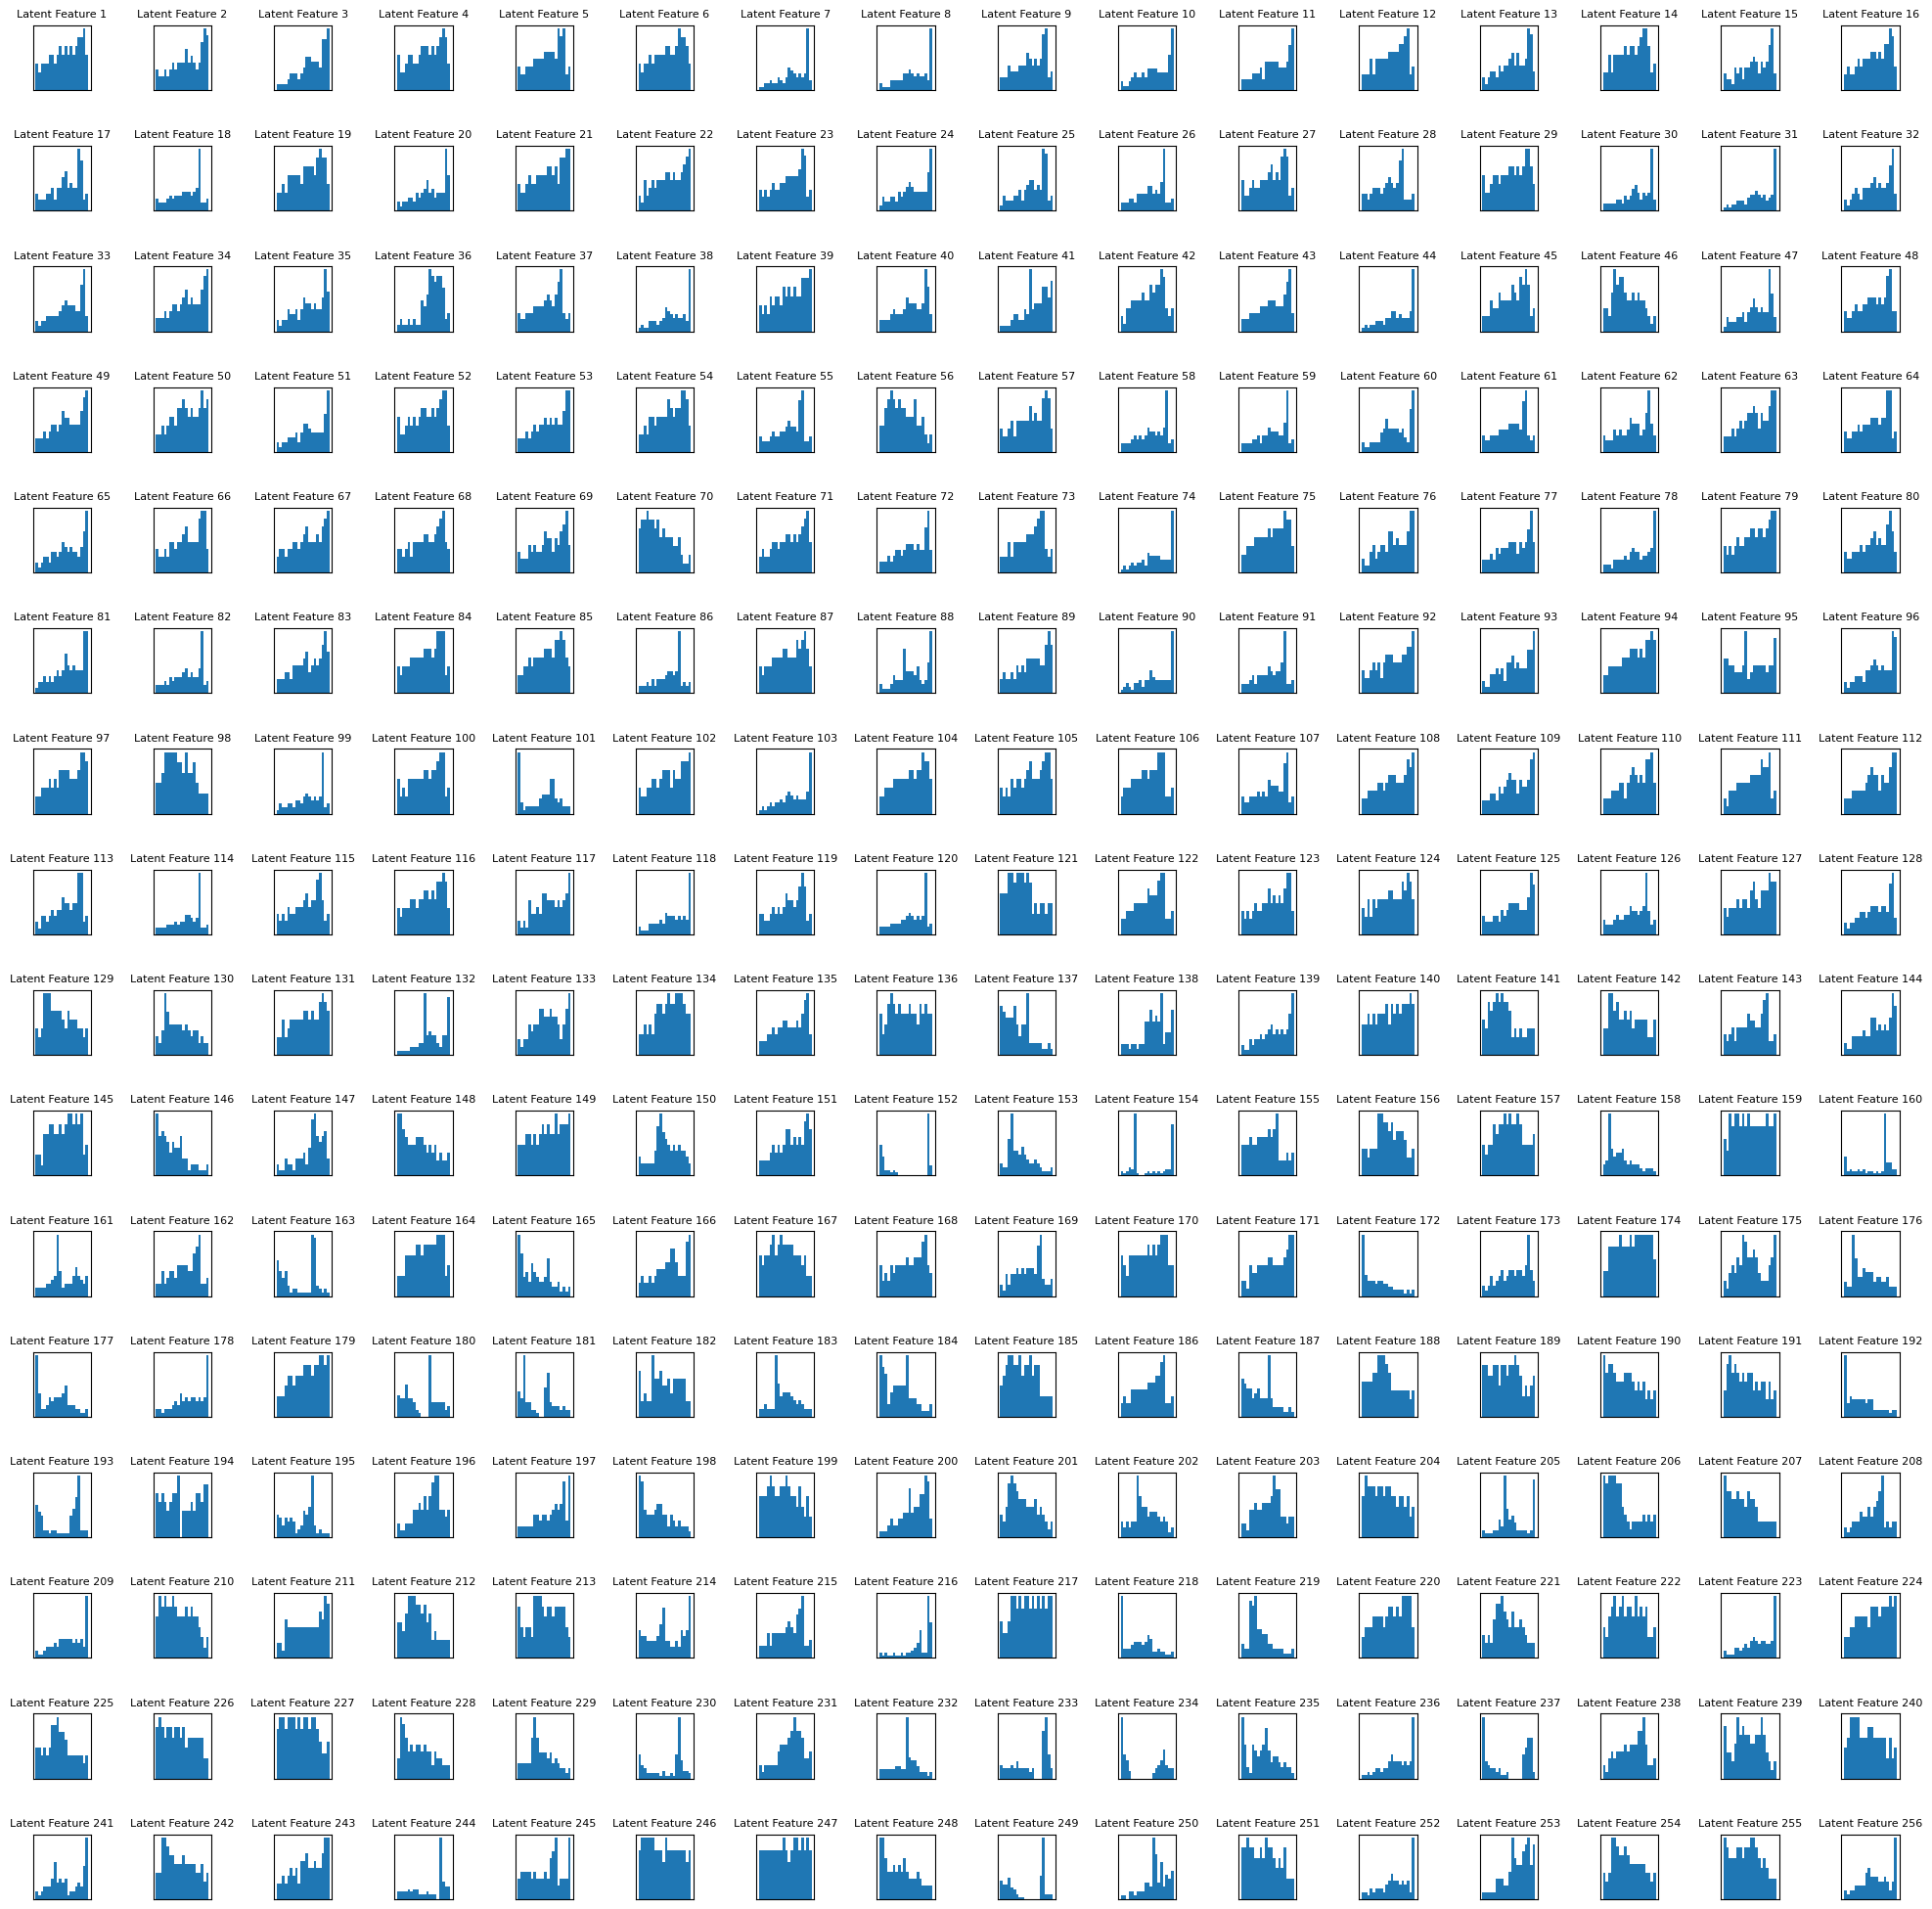

In [8]:
# Define grid size
rows, cols = 16, 16

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.tight_layout(pad=2.0)  # Adjust spacing

# Iterate over each feature (column) and plot histogram
for i in range(outputs_AD.size(1)):  # 256 features
    row, col = divmod(i, cols)  # Get row and col index
    ax = axes[row, col]
    ax.hist(outputs_AD[:, i].cpu(), bins=20)
    ax.set_title(f"Latent Feature {i+1}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Save the full figure
plt.savefig("AD_all.png", dpi=300, bbox_inches='tight')
plt.show()

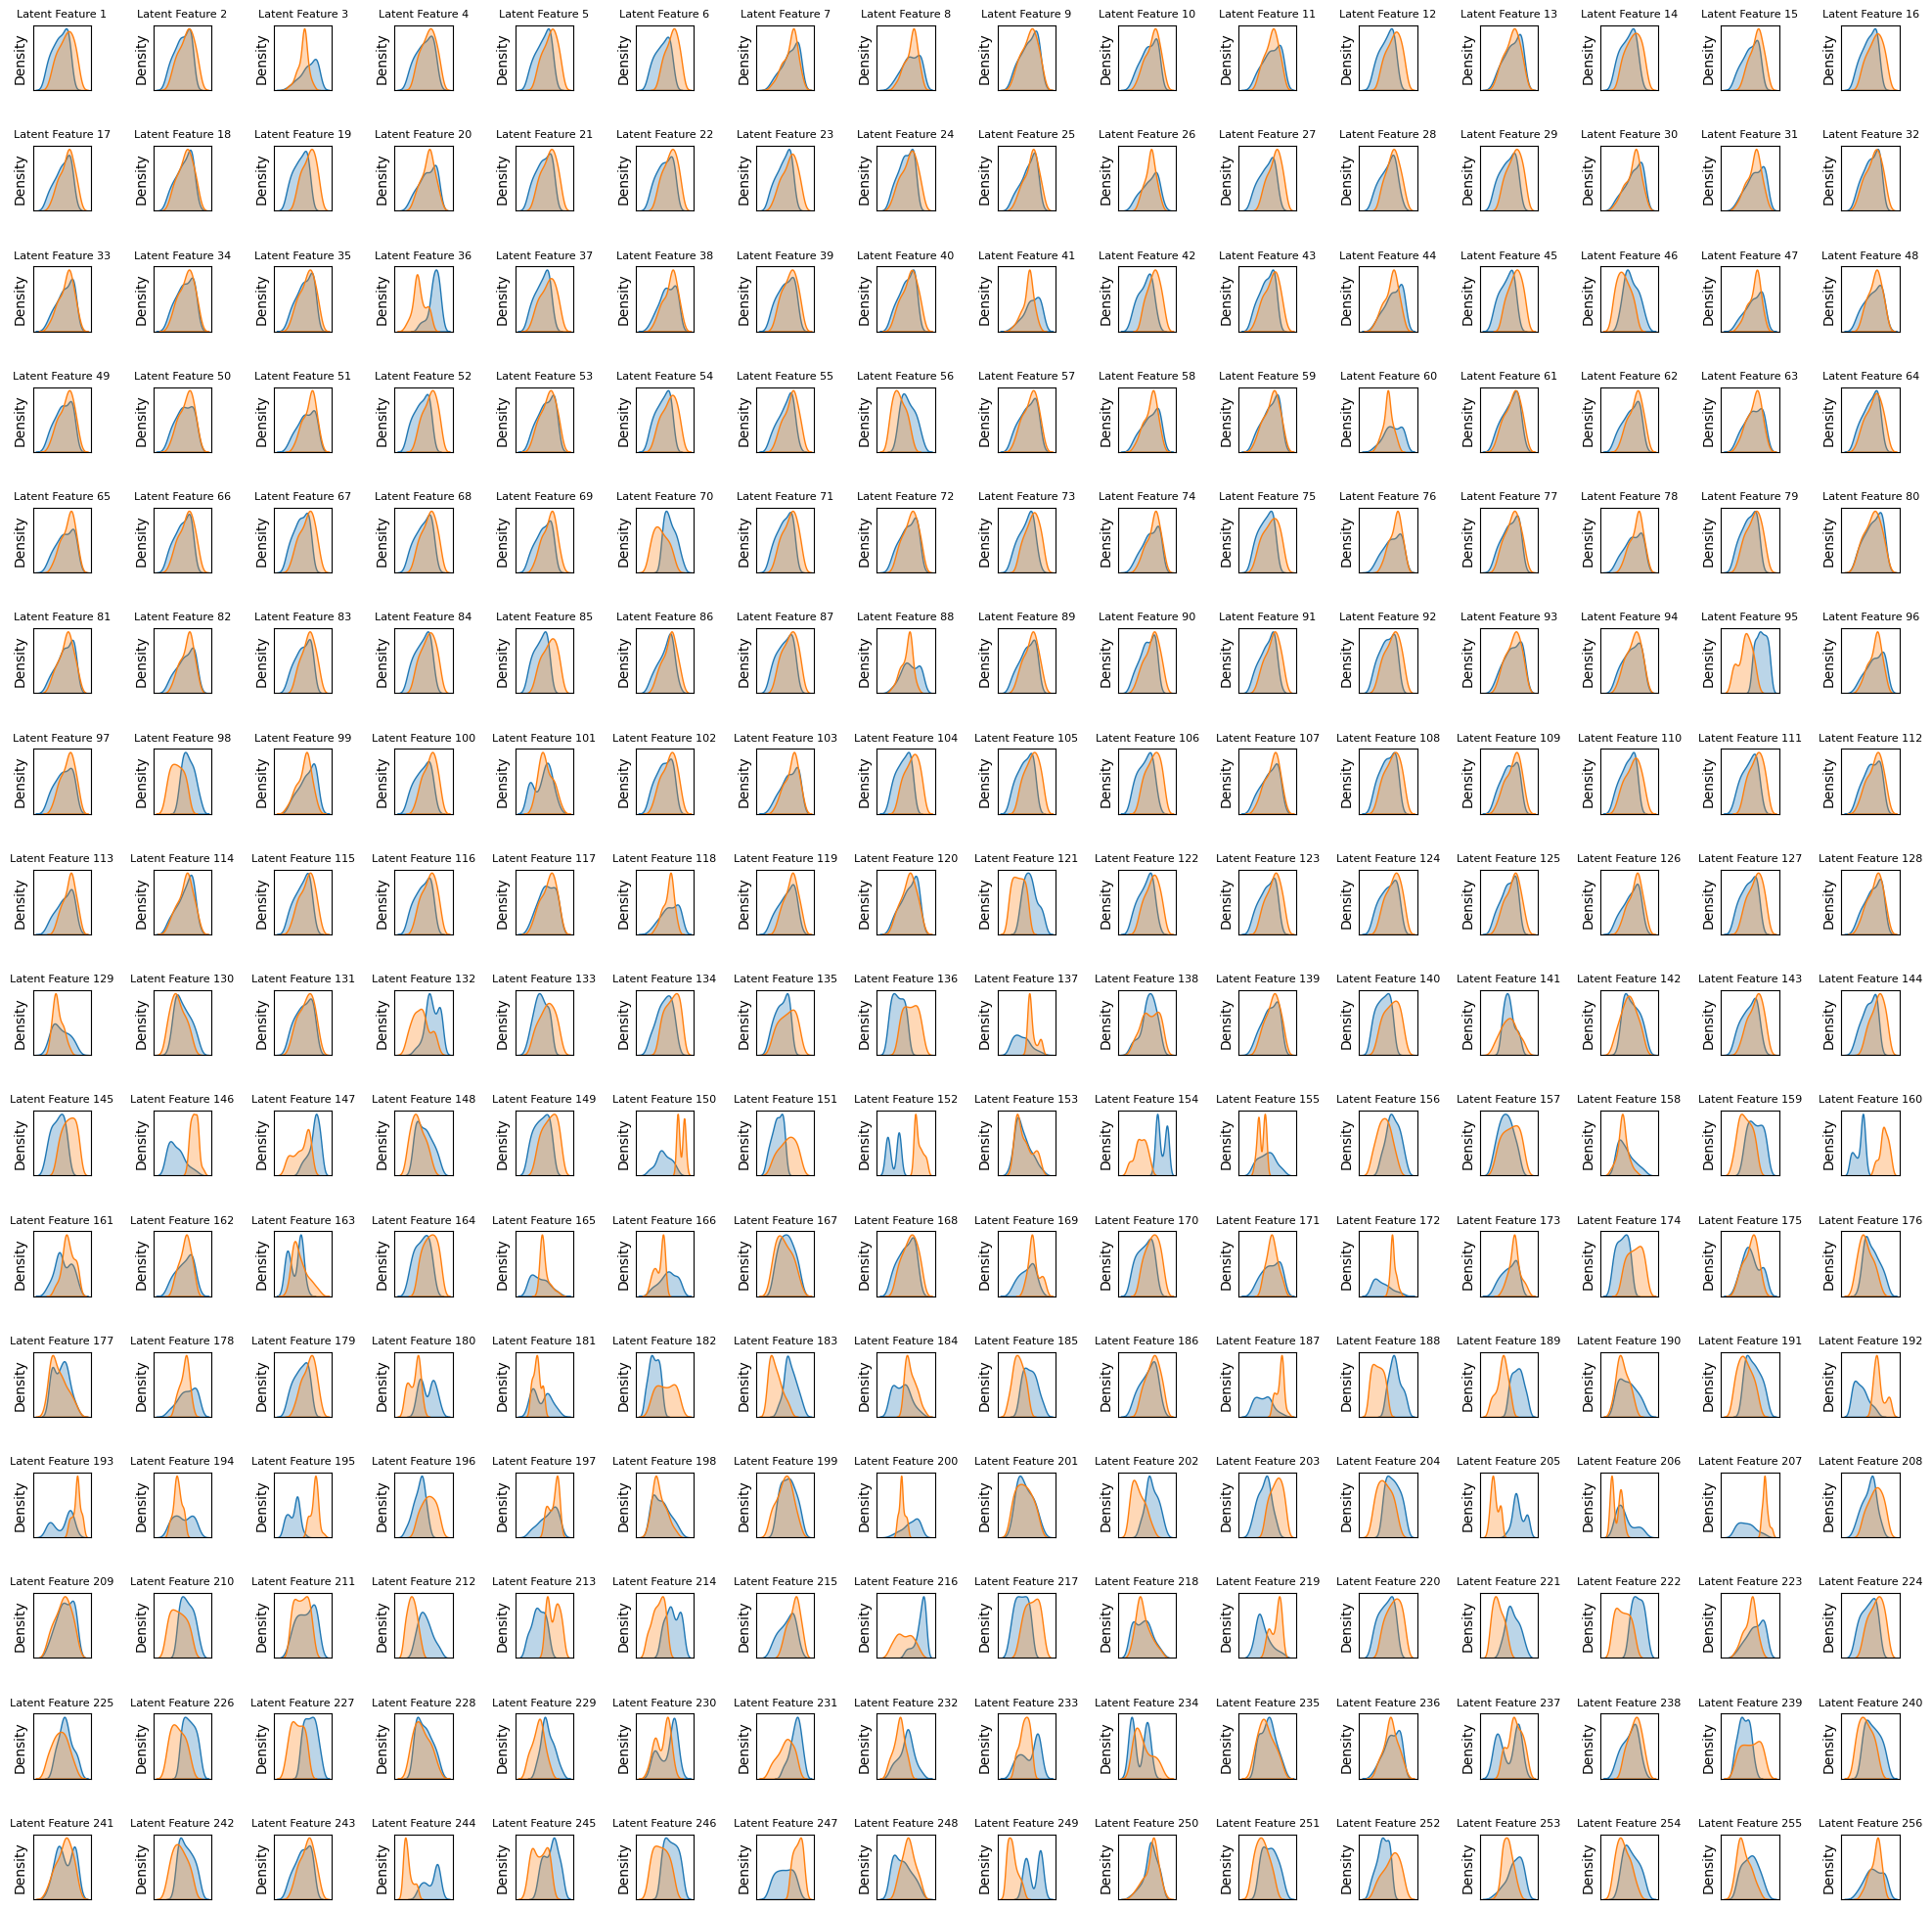

In [9]:
# Define grid size
rows, cols = 16, 16

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.tight_layout(pad=2.0)  # Adjust spacing

# Iterate over each feature (column) and plot density curve
for i in range(outputs_AD.size(1)):  # 256 features
    row, col = divmod(i, cols)  # Get row and col index
    ax = axes[row, col]

    # Density plot
    sns.kdeplot(outputs_AD[:, i].cpu(), ax=ax,
                fill=True, alpha=0.3, label="AD")

    sns.kdeplot(outputs_CN[:, i].cpu(), ax=ax,
                fill=True, alpha=0.3, label="CN")

    ax.set_title(f"Latent Feature {i+1}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Save the full figure
plt.savefig("all density plots - comparision.png",
            dpi=300, bbox_inches='tight')
plt.show()

### Shapiro-Wilk Test to Check Normality of the Latent Features

In [14]:
# Assuming:
# non_dementia_data = (84 samples, 256 features)
# dementia_data = (84 samples, 256 features)

# Initialize p-value storage
p_non_dementia = []
p_dementia = []

# Perform Shapiro-Wilk for all features in both groups - Null Hypothesis: Normal Distribution
for feature_idx in range(outputs_CN.size(1)):
    # Non-dementia group
    _, p_nd = shapiro(outputs_CN[:, feature_idx].cpu())
    p_non_dementia.append(p_nd)

    # Dementia group
    _, p_d = shapiro(outputs_AD[:, feature_idx].cpu())
    p_dementia.append(p_d)

# Combine all p-values into a single list (512 tests)
all_p_values = p_non_dementia + p_dementia

# Apply Bonferroni correction
alpha = 0.05
reject_null_ie_normal, corrected_p_values, _, _ = multipletests(
    all_p_values,
    alpha=alpha,
    method='bonferroni'
)

# Split results back into groups
reject_normal_non_dementia = reject_null_ie_normal[:256]
reject_normal_dementia = reject_null_ie_normal[256:]

non_normal_feature_idx = []
normal_feature_idx = []
for i in range(len(reject_normal_non_dementia)):
    # If data is not normal in dementia or non-dementia group, add to list
    if reject_normal_non_dementia[i] or reject_normal_dementia[i]:
        non_normal_feature_idx.append(i)
    else:
        normal_feature_idx.append(i)

non_normal_feature_idx = np.array(non_normal_feature_idx)
normal_feature_idx = np.array(normal_feature_idx)
print(f"Number of non-normal features: {len(non_normal_feature_idx)}")
print(f"Number of normal features: {len(normal_feature_idx)}")

Number of non-normal features: 33
Number of normal features: 223


In [15]:
p_non_dementia
p_dementia
idx = []
for i in range(len(p_non_dementia)):
    if p_non_dementia[i] >= 0.05 and p_dementia[i] >= 0.05:
        idx.append(i)
len(idx)

8

### Levene’s Test to check if the variances of the two groups (dementia vs. non-dementia) are equal for a feature

In [10]:
# Assuming:
# non_dementia_data: shape (84, 256)
# dementia_data: shape (84, 256)
# normal_feature_idx: list of indices (e.g., [0, 5, 12, 63, ..., 248]) for the normal features

# Initialize p-values for Levene’s test
p_values = []

# Loop through each normal feature
for feature_idx in normal_feature_idx:
    # Perform Levene’s test (center='median' is default in scipy) - Null Hypothesis: equal variances
    _, p = levene(outputs_CN[:, feature_idx].cpu(),
                  outputs_AD[:, feature_idx].cpu())
    p_values.append(p)

# Apply Bonferroni correction
alpha = 0.05
reject_null_ie_equal_variance, corrected_p_values, _, _ = multipletests(
    pvals=p_values,
    alpha=alpha,
    method='bonferroni'
)

# the values in normal_equal_variance and normal_unequal_variance are indexes of normal_feature_idx
normal_equal_variance_idx = normal_feature_idx[~reject_null_ie_equal_variance]
normal_unequal_variance_idx = normal_feature_idx[reject_null_ie_equal_variance]

print(
    f"Indexes of normal features with equal variance:\n{normal_equal_variance_idx}")
print(
    f"\nIndexes of normal features with unequal variance:\n{normal_unequal_variance_idx}")

Indexes of normal features with equal variance:
[  0   1   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  26  27  28  30  31  32  33  34  35  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  88  89  90  91  92  93  94  95  96
  97  98  99 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 118 119 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135
 137 138 139 141 142 143 144 147 148 155 156 158 160 163 166 167 169 173
 174 175 176 178 182 184 185 187 188 190 195 197 198 200 201 202 203 204
 207 208 209 210 211 213 214 216 217 219 220 221 222 223 224 225 226 227
 228 230 231 234 235 237 239 241 242 244 245 247 249 250 251 252 253 254]

Indexes of normal features with unequal variance:
[  2  25  59  87 117 128 140 145 150 161 168 170 172 177 181 183 186 189
 193 194 199 206 238 246

### Student’s t-test (Normal distribution - equal variances)

Significant Features After Bonferroni Correction:
Feature 1:
  - Adjusted p-value = 0.000140
  - Cohen’s d = 0.796 (effect size)
Feature 5:
  - Adjusted p-value = 0.000000
  - Cohen’s d = 1.003 (effect size)
Feature 6:
  - Adjusted p-value = 0.000000
  - Cohen’s d = 1.436 (effect size)
Feature 12:
  - Adjusted p-value = 0.000000
  - Cohen’s d = 1.017 (effect size)
Feature 14:
  - Adjusted p-value = 0.000412
  - Cohen’s d = 0.759 (effect size)
Feature 15:
  - Adjusted p-value = 0.000008
  - Cohen’s d = 0.887 (effect size)
Feature 16:
  - Adjusted p-value = 0.000042
  - Cohen’s d = 0.835 (effect size)
Feature 19:
  - Adjusted p-value = 0.000000
  - Cohen’s d = 1.299 (effect size)
Feature 21:
  - Adjusted p-value = 0.000314
  - Cohen’s d = 0.768 (effect size)
Feature 22:
  - Adjusted p-value = 0.000298
  - Cohen’s d = 0.770 (effect size)
Feature 23:
  - Adjusted p-value = 0.000071
  - Cohen’s d = 0.818 (effect size)
Feature 27:
  - Adjusted p-value = 0.000000
  - Cohen’s d = 1.126 (effect

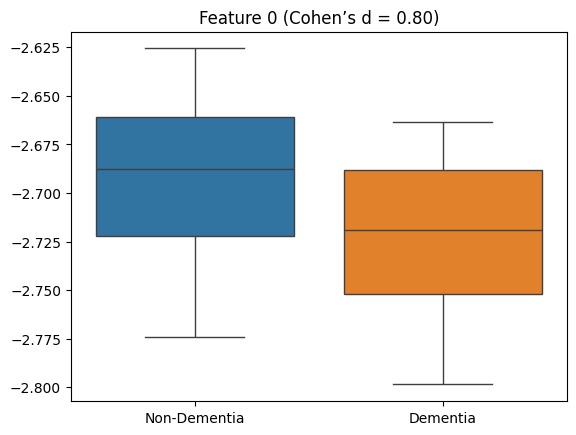

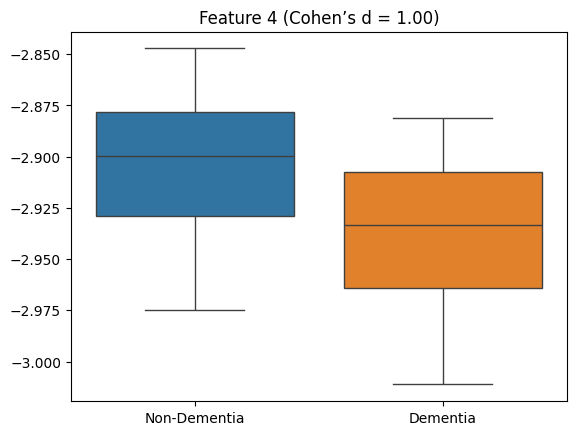

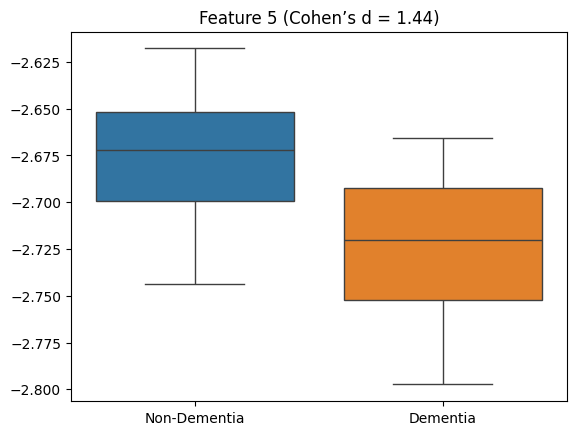

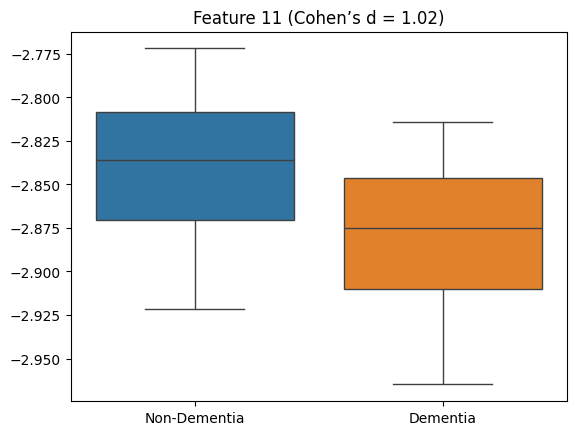

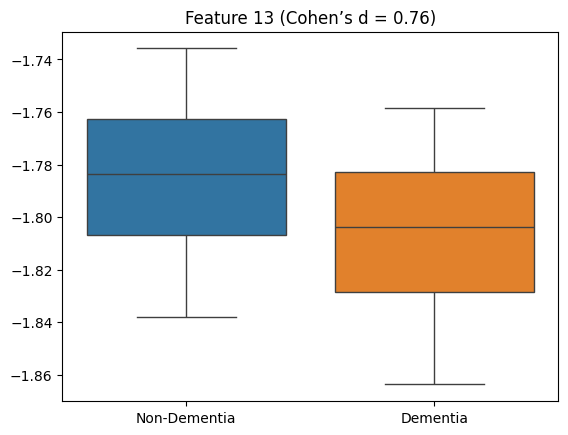

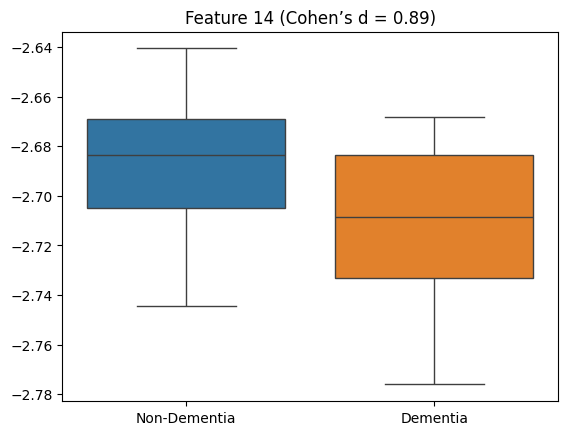

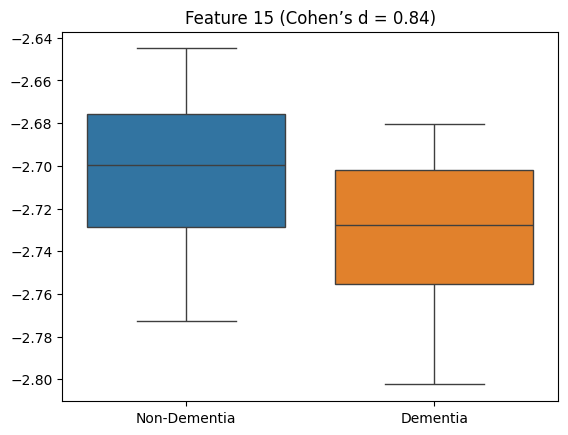

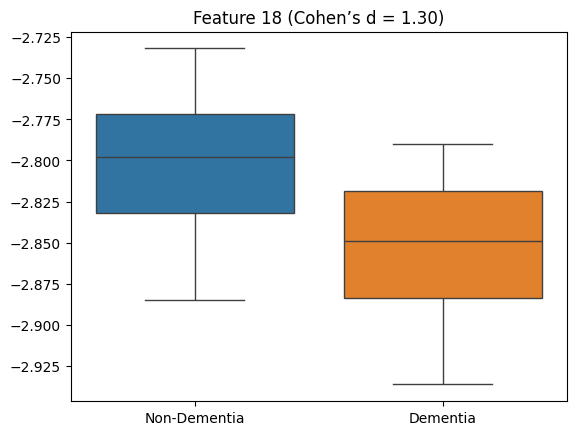

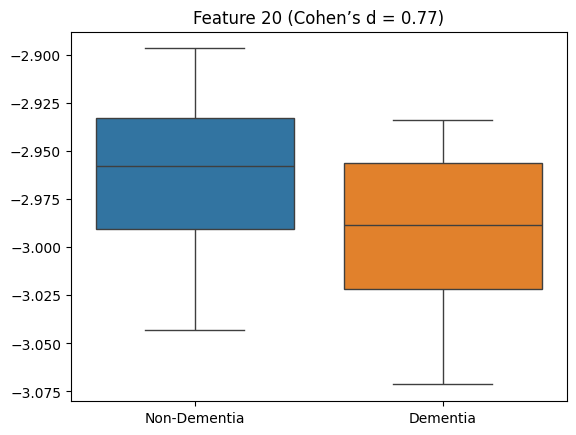

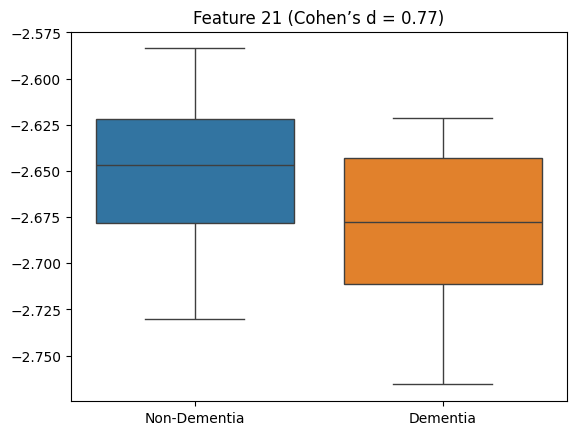

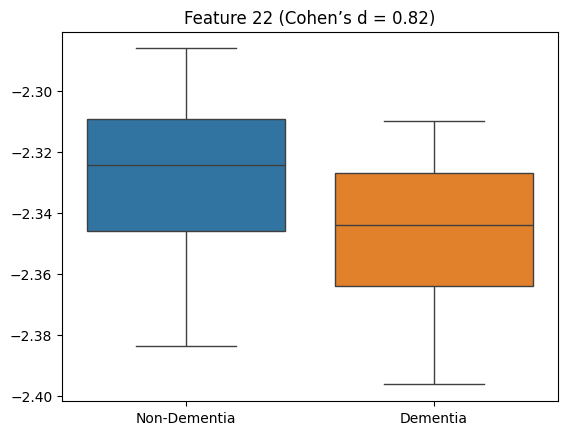

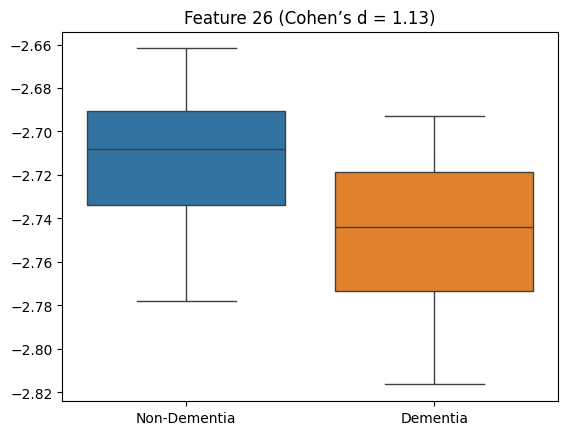

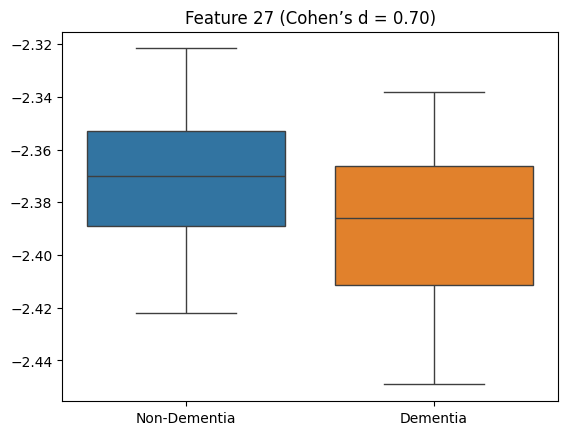

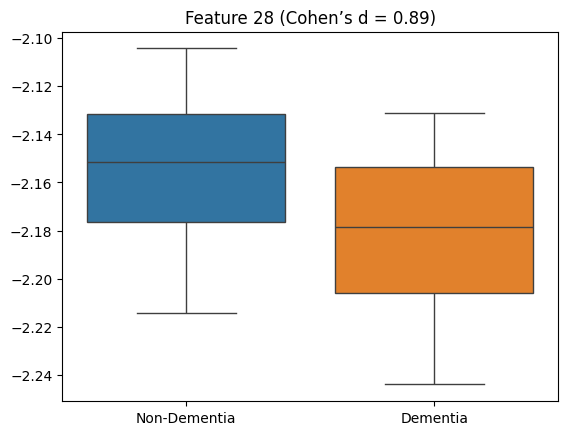

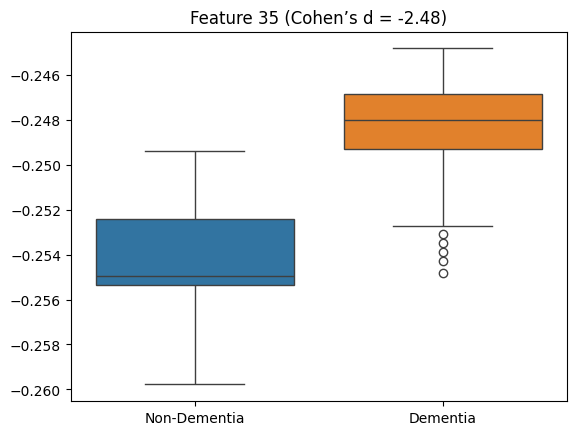

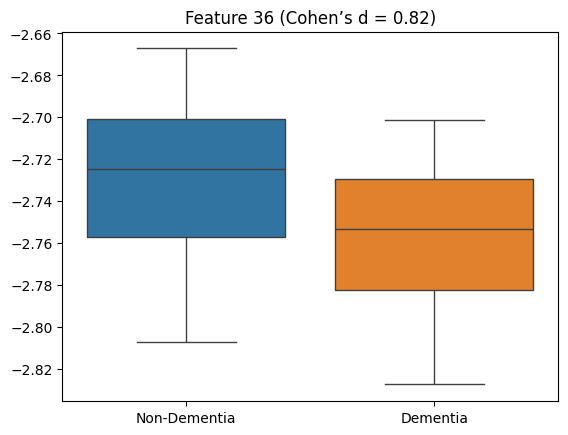

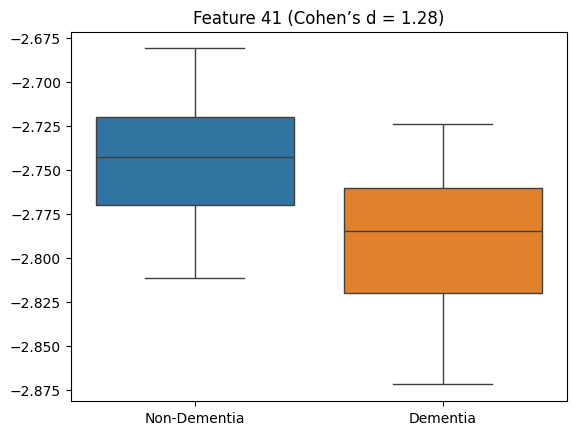

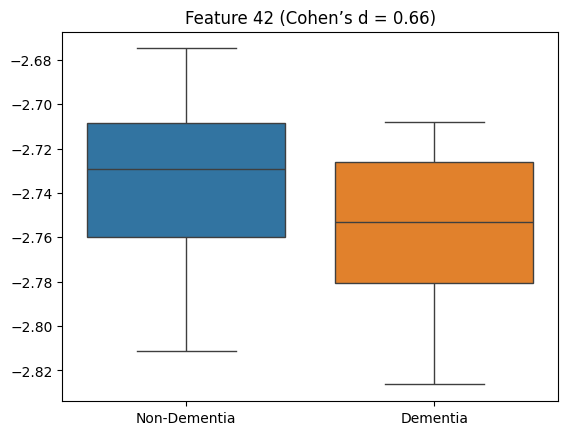

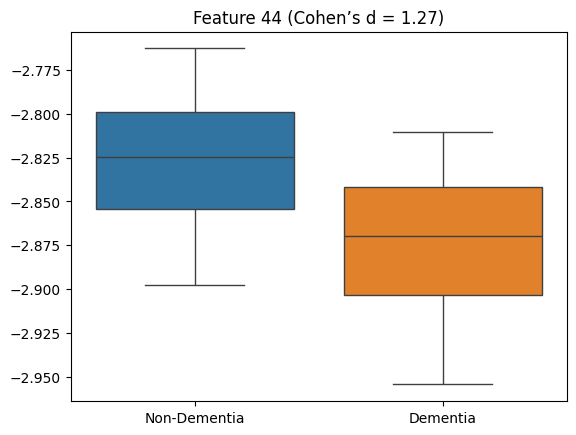

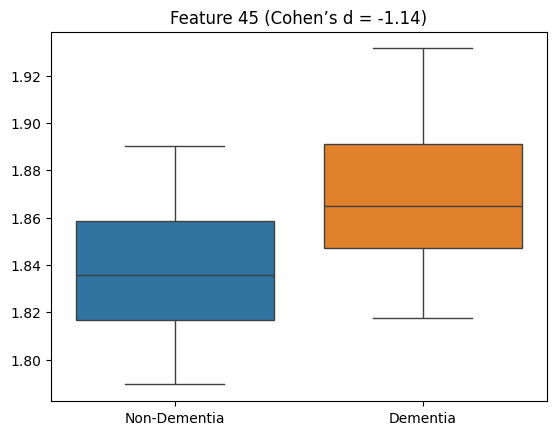

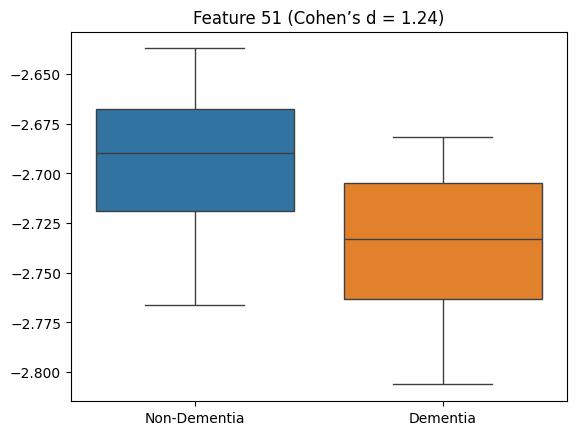

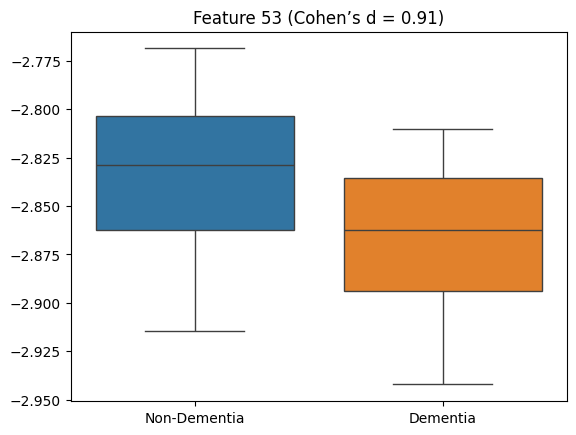

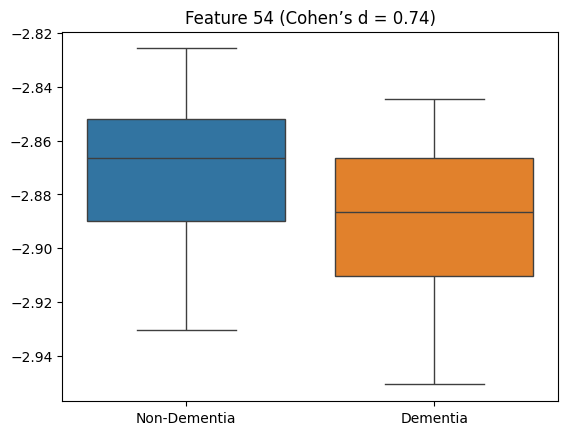

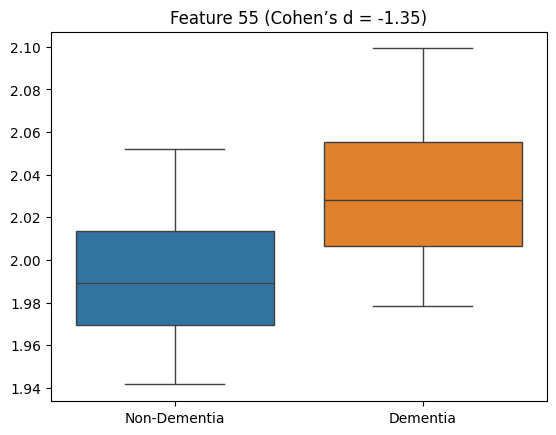

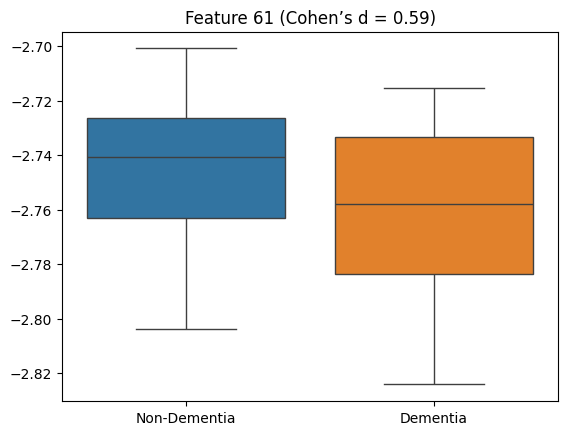

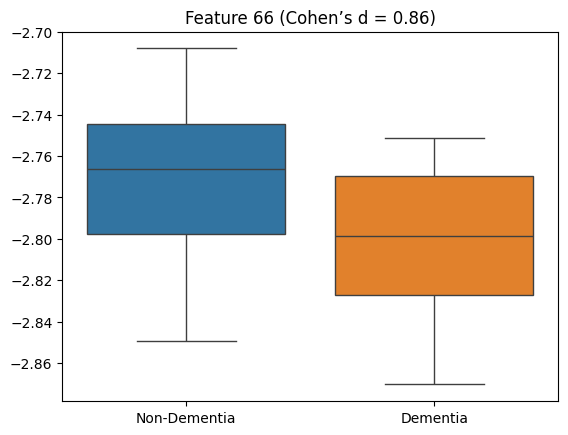

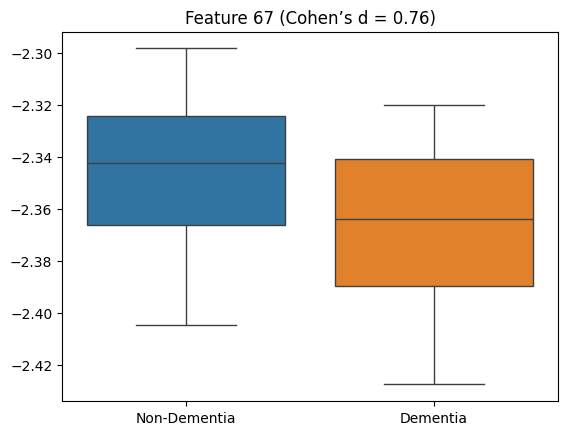

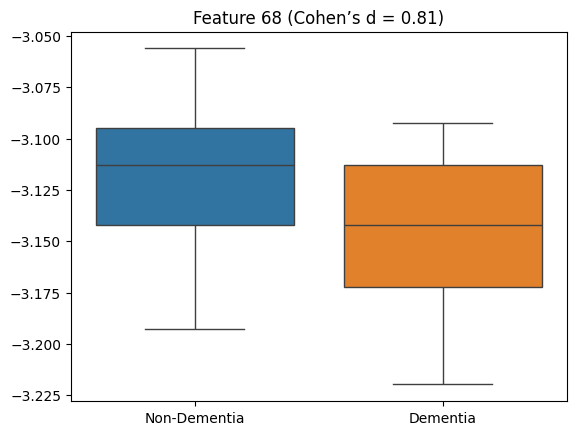

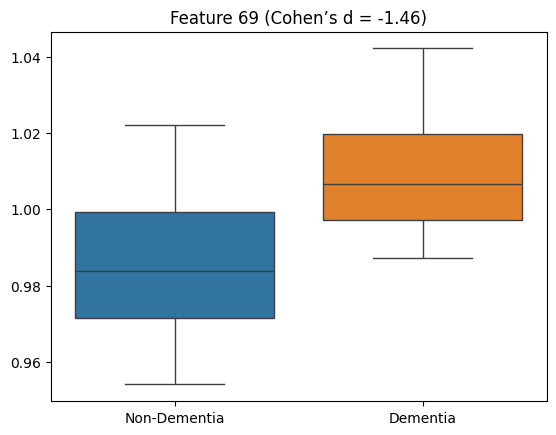

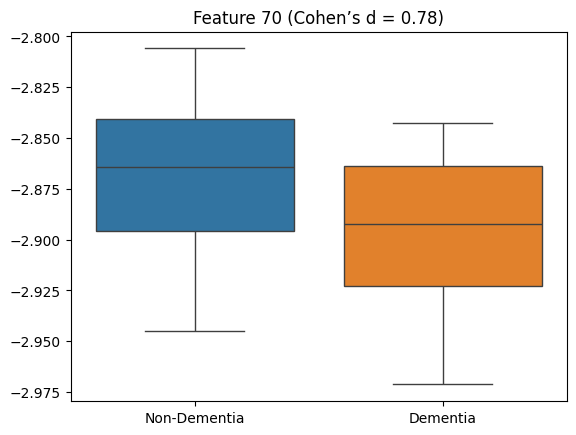

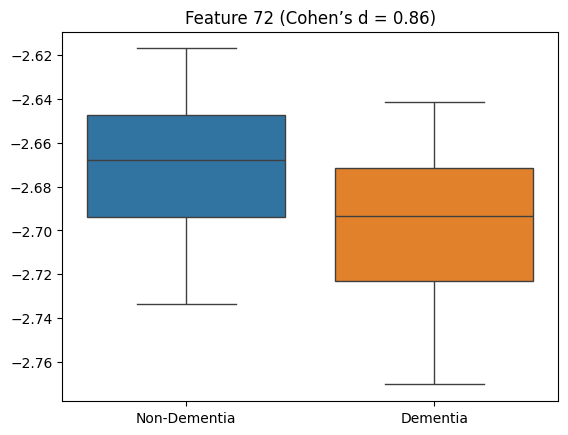

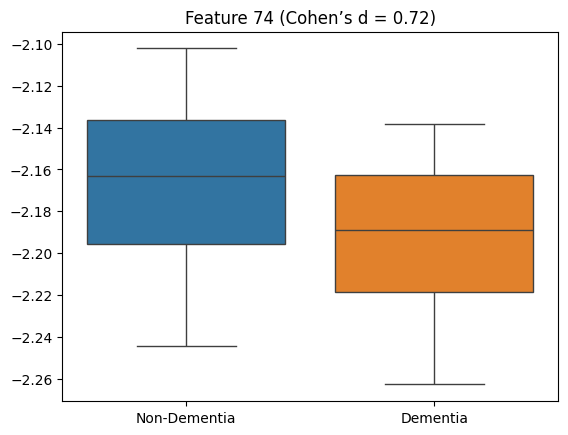

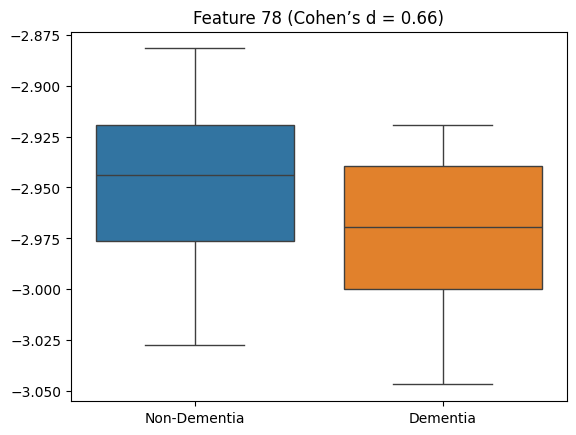

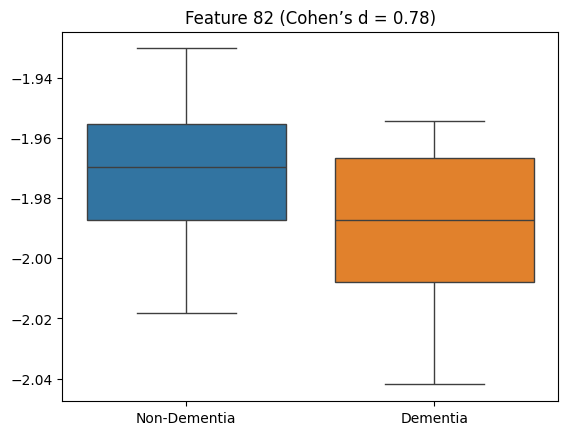

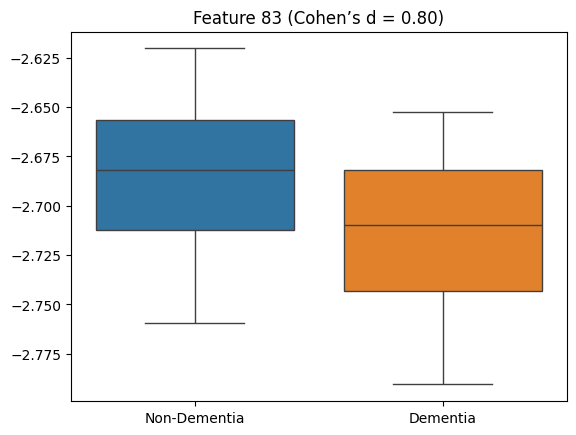

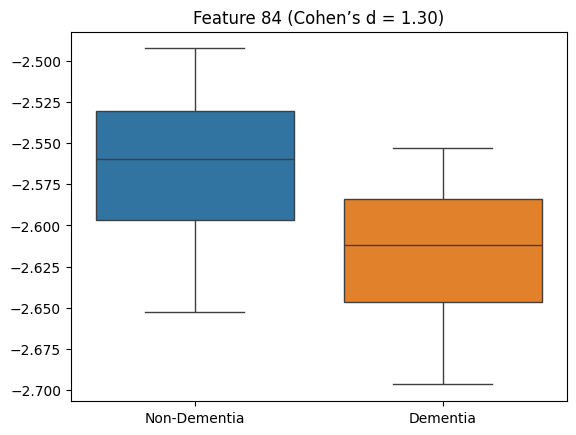

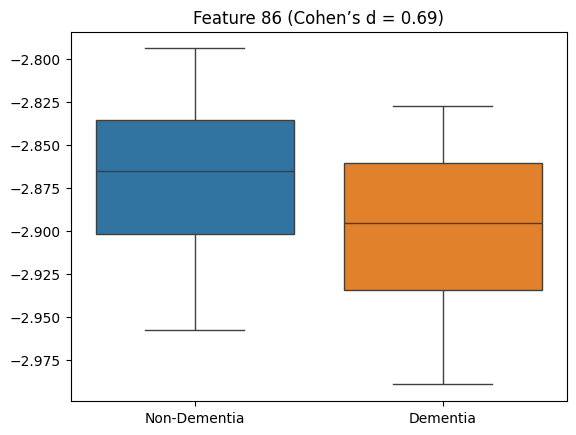

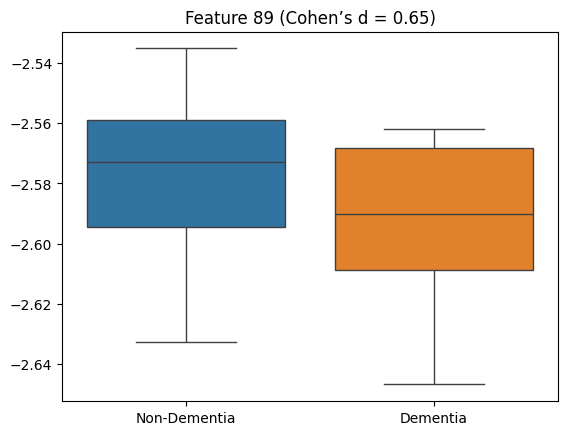

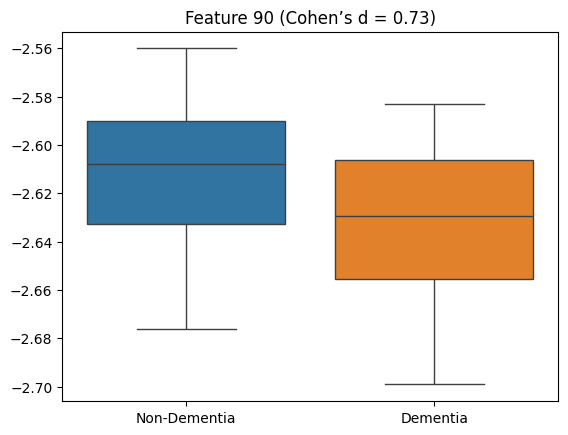

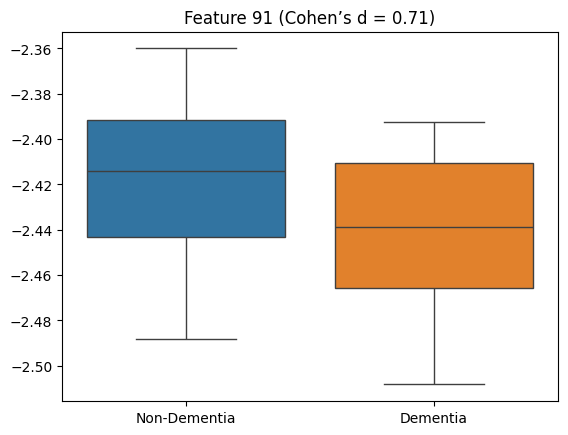

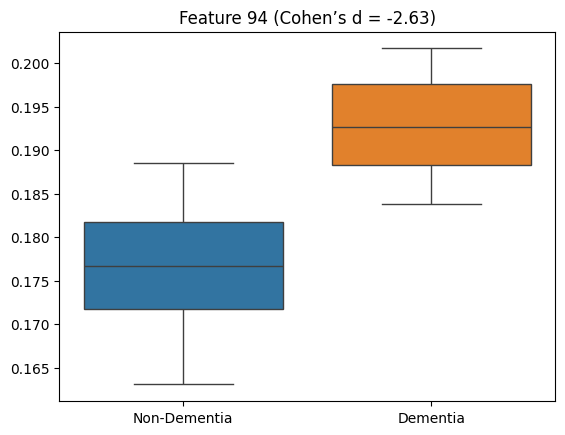

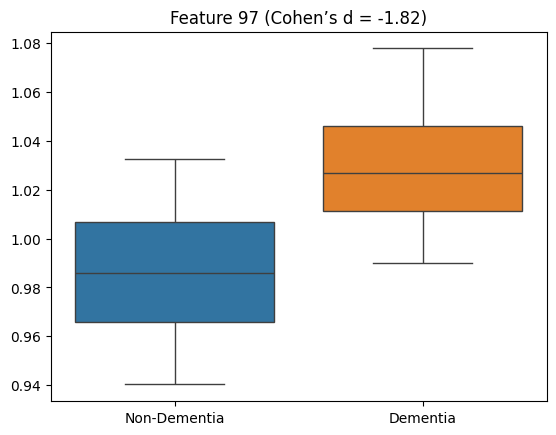

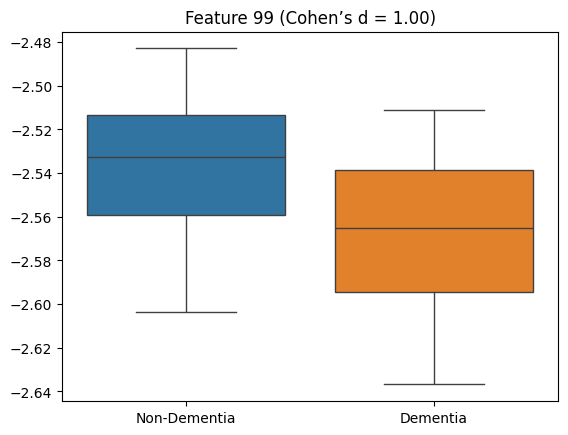

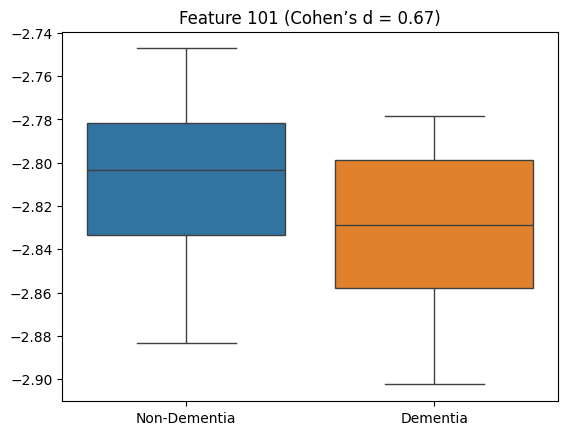

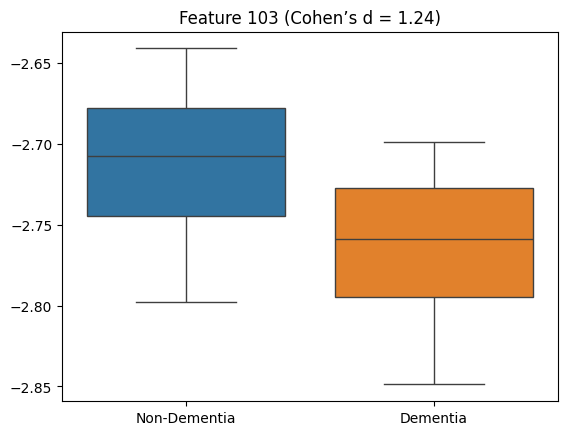

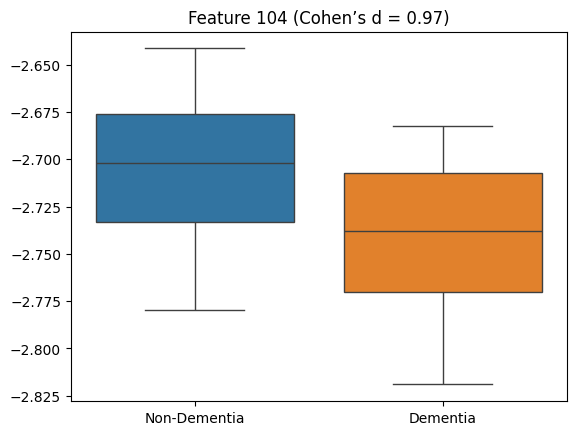

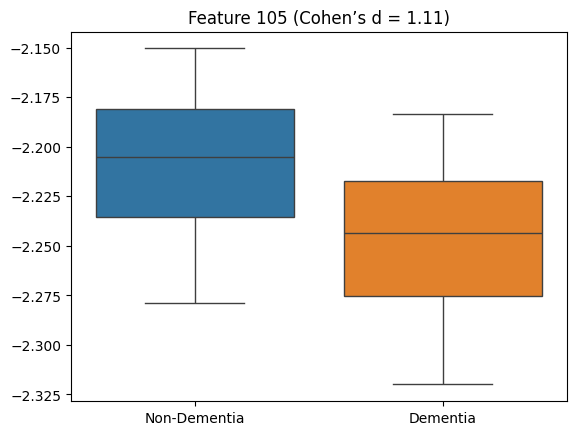

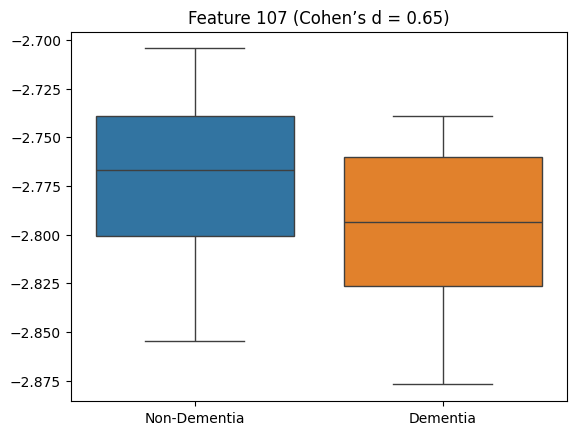

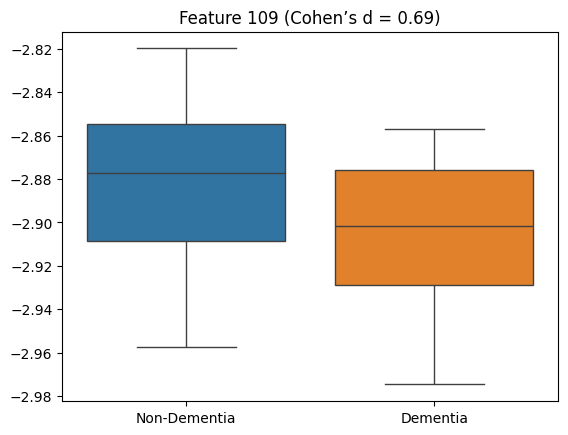

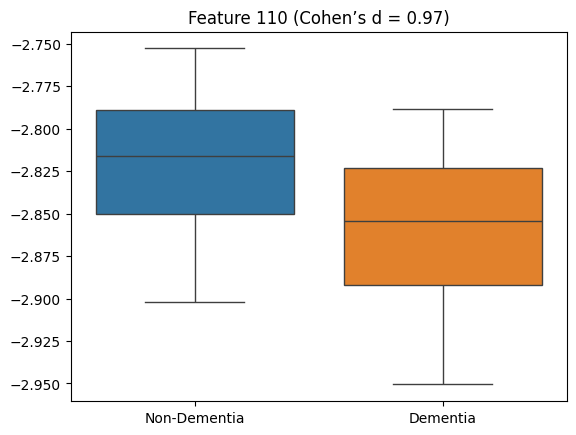

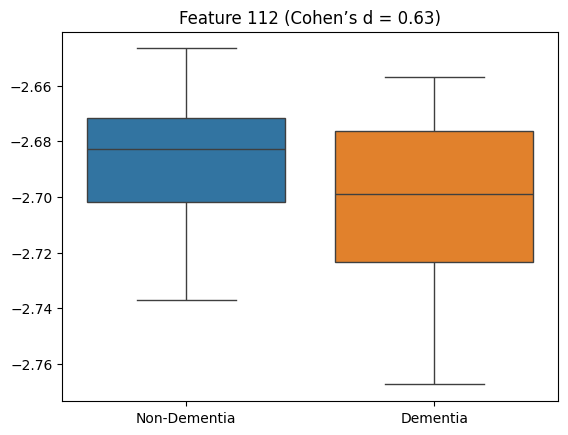

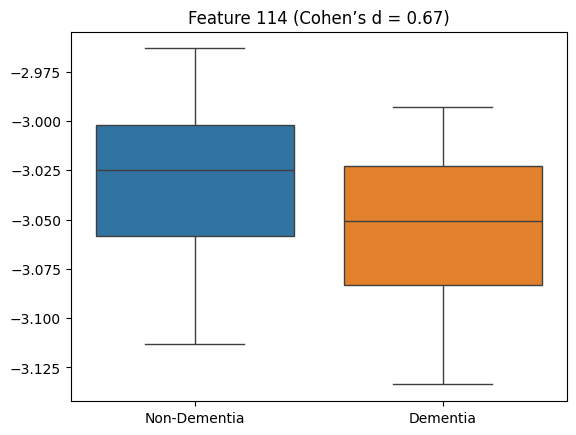

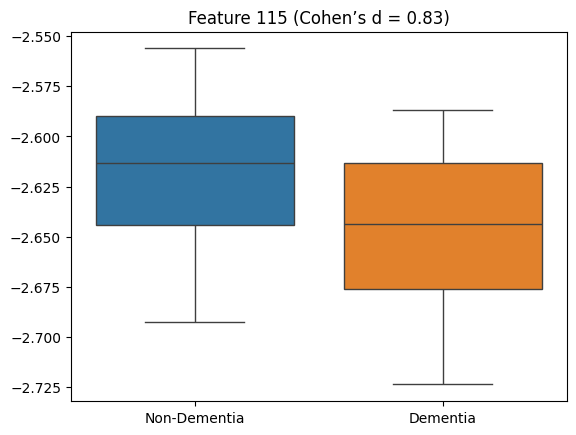

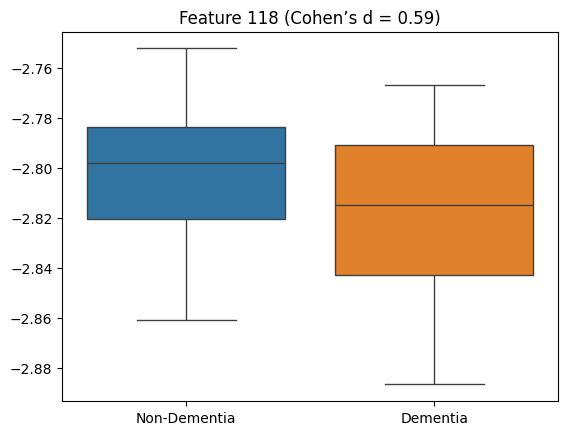

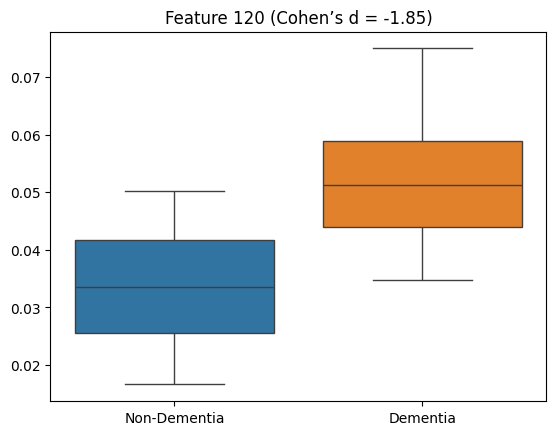

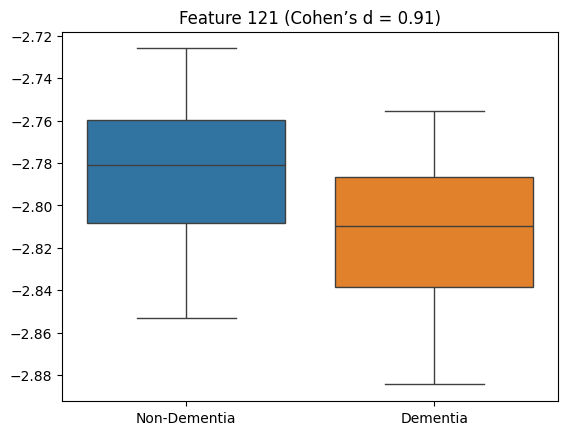

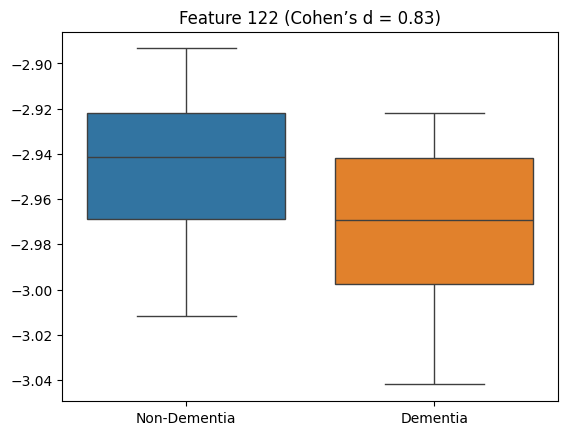

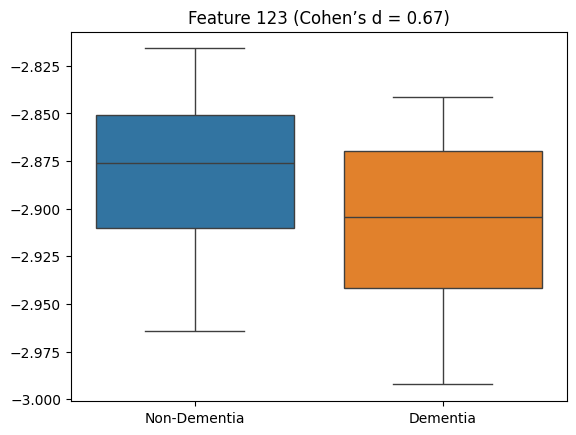

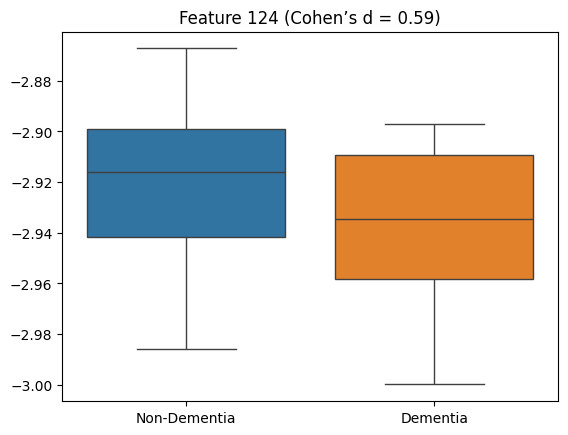

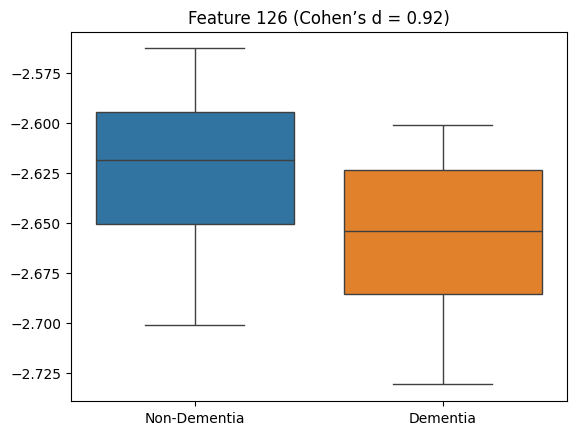

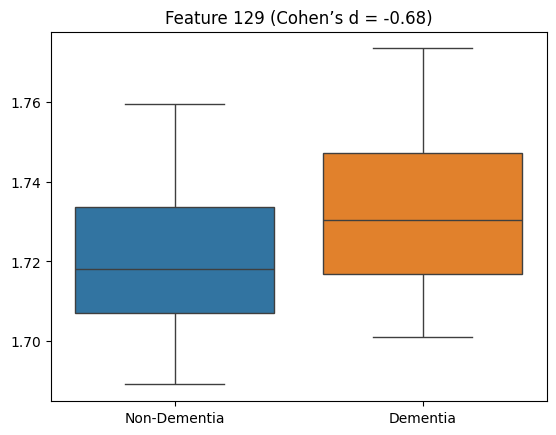

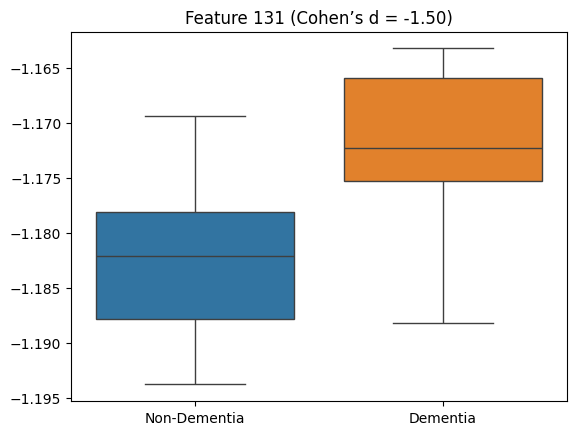

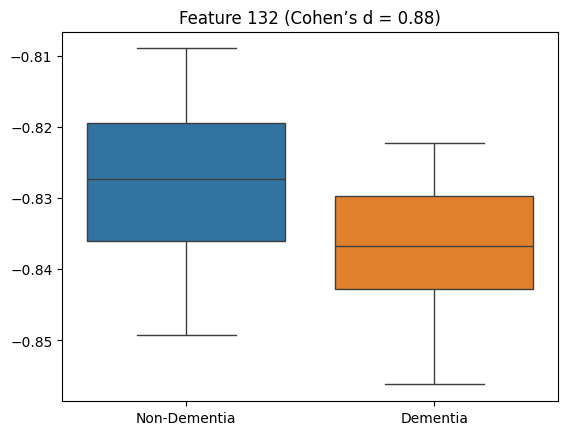

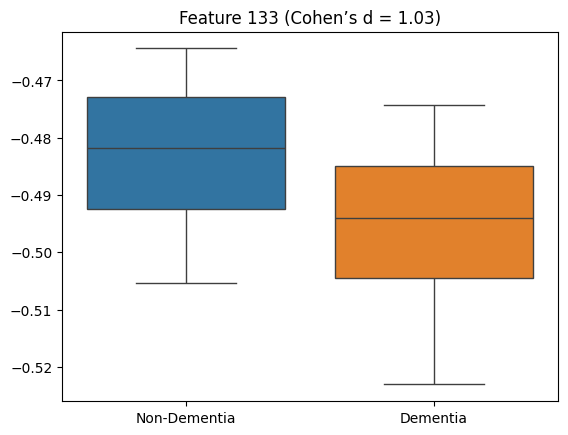

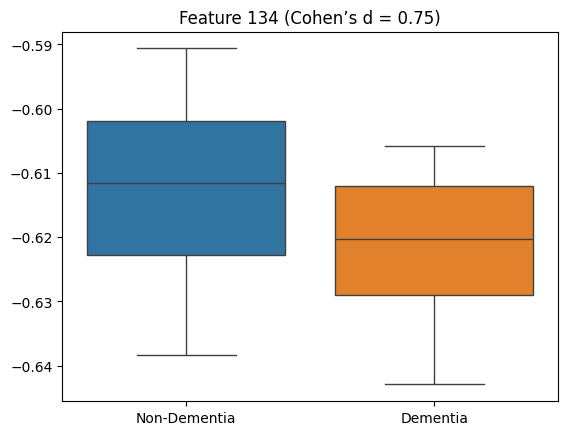

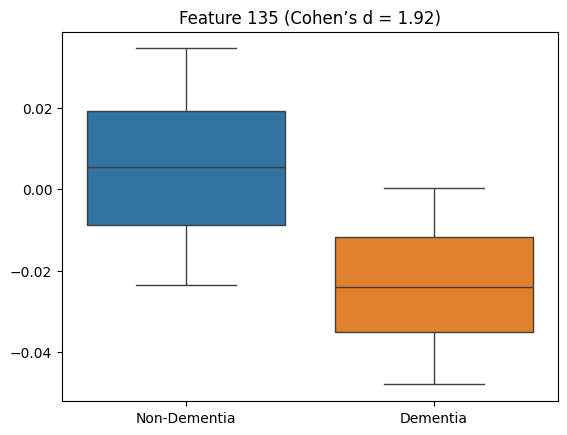

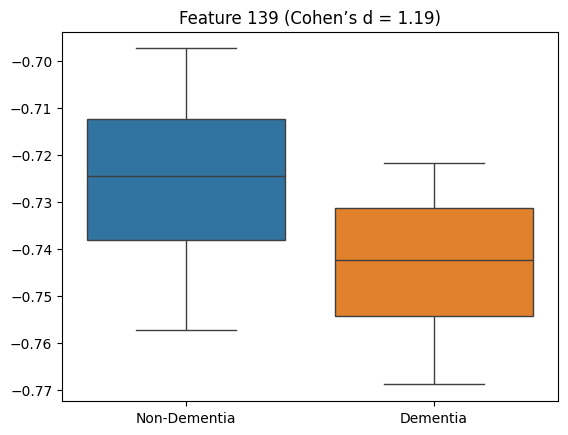

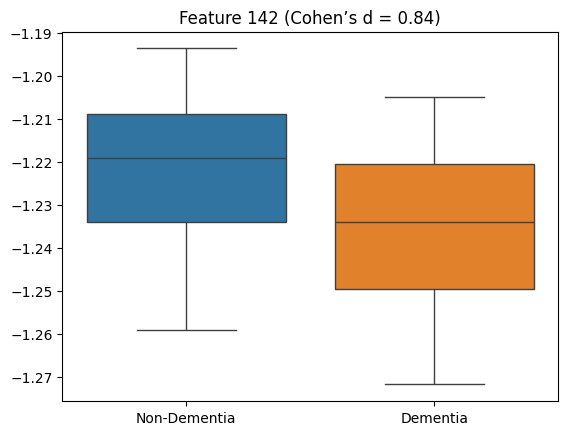

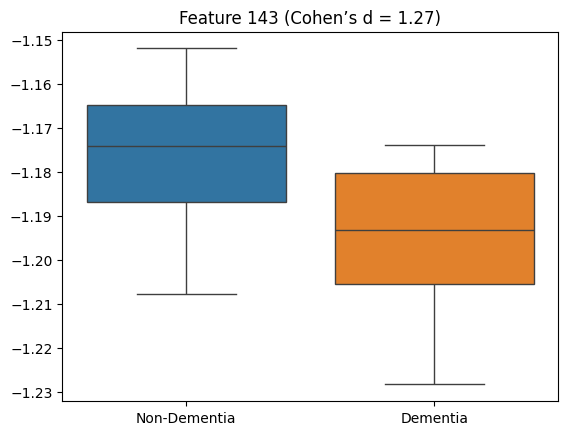

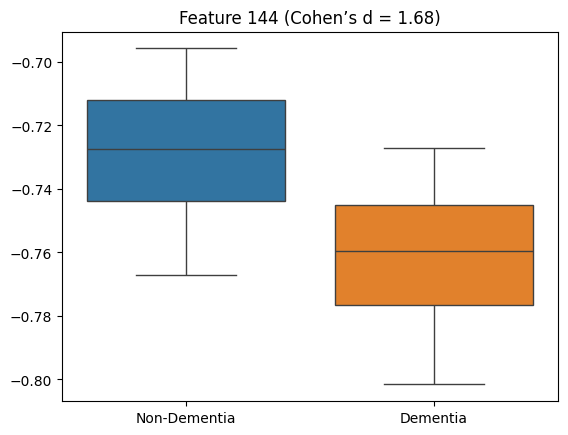

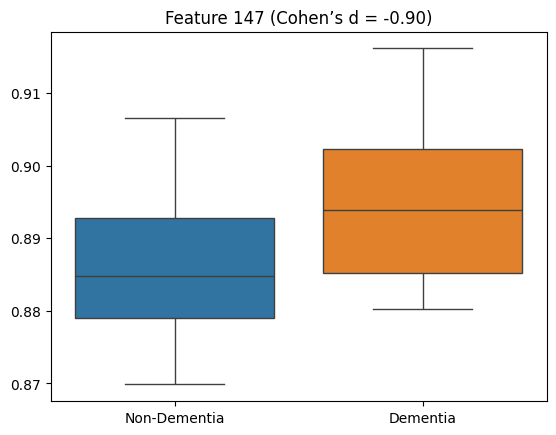

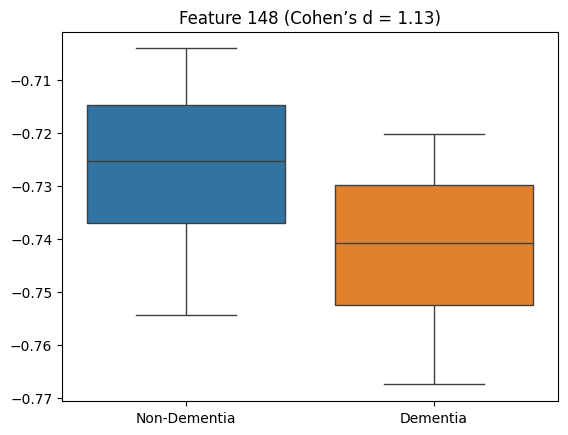

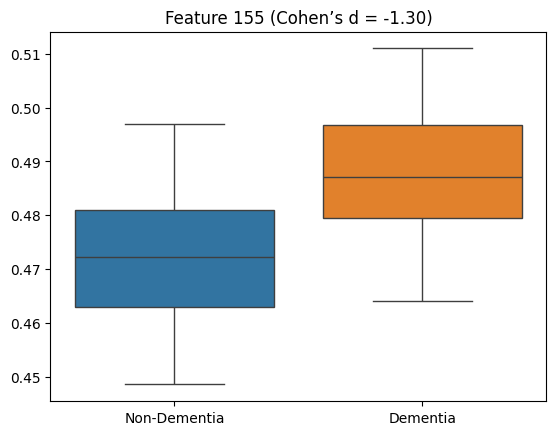

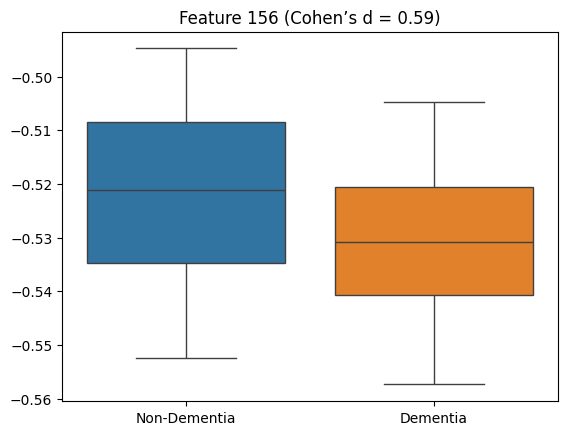

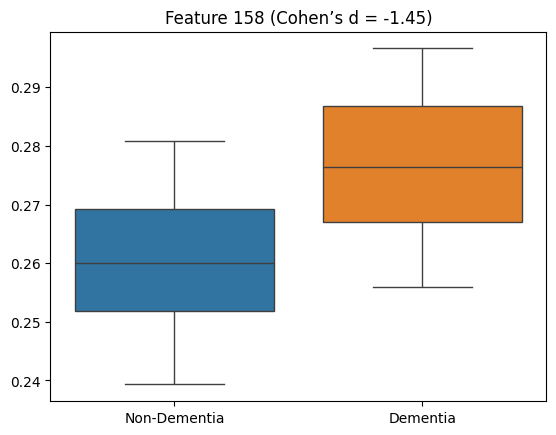

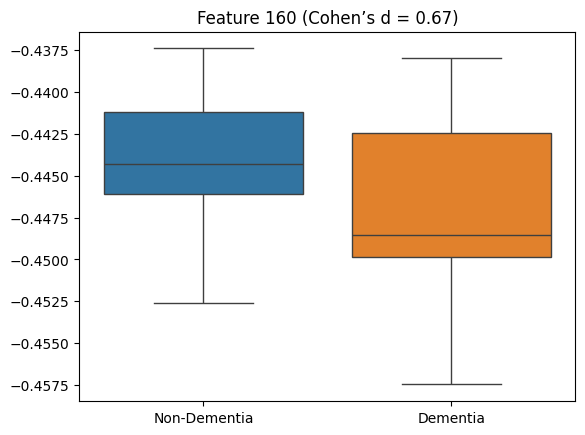

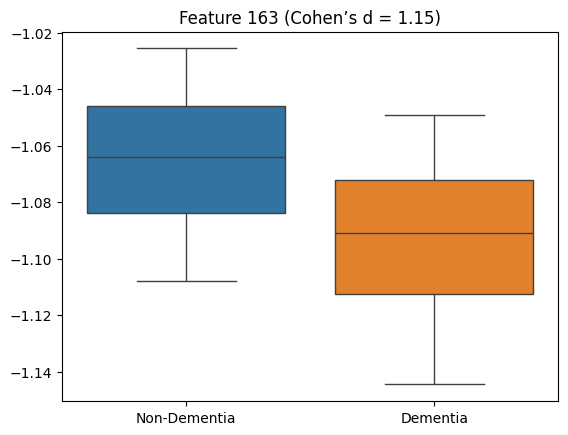

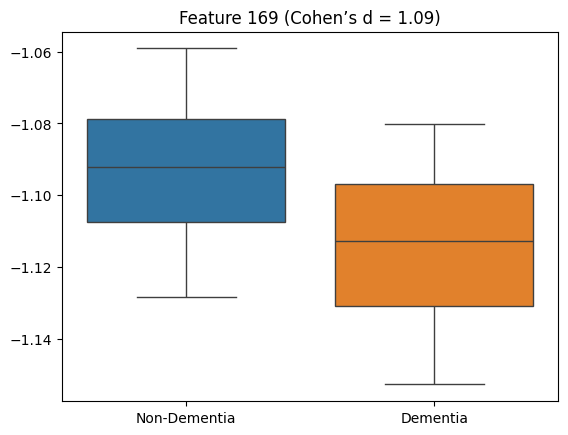

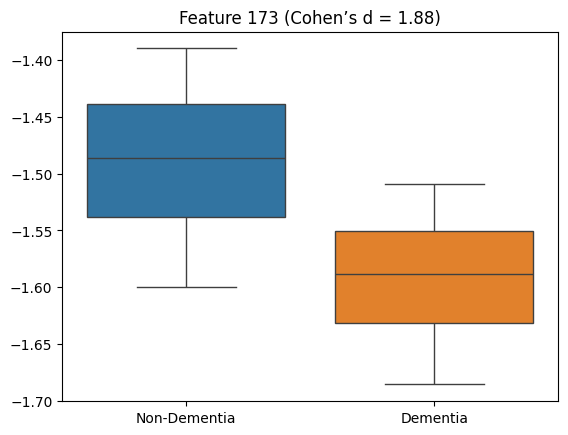

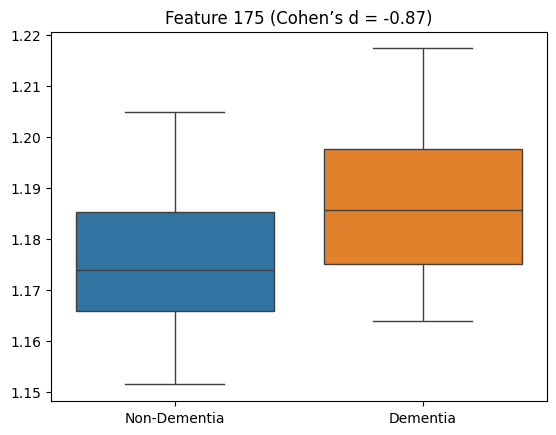

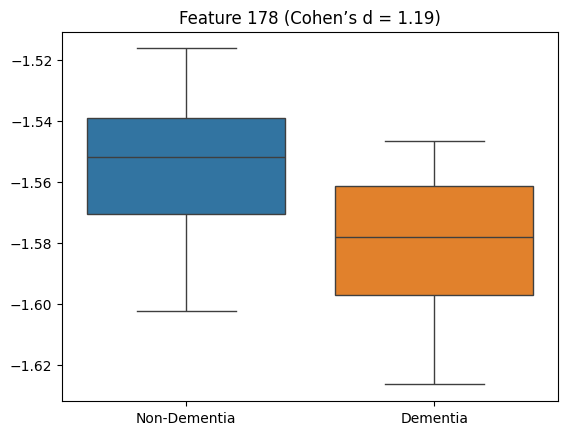

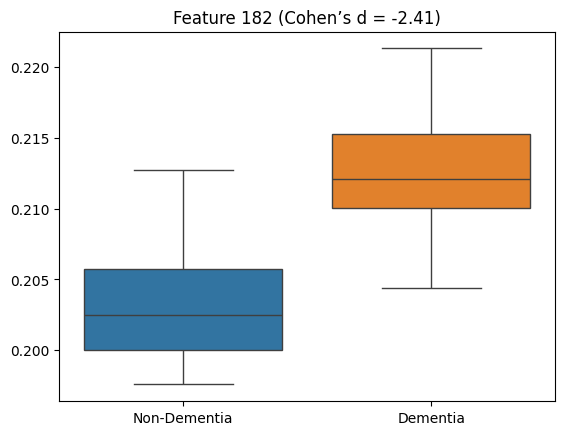

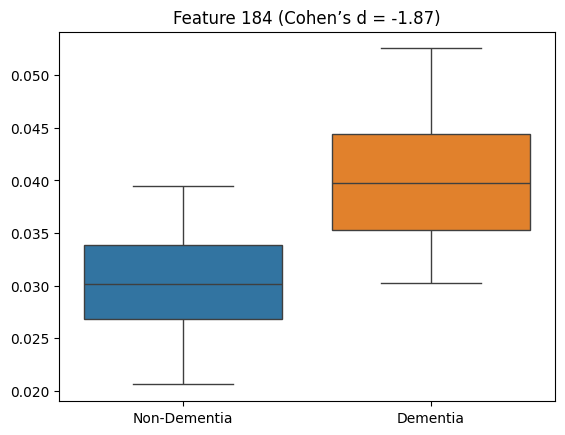

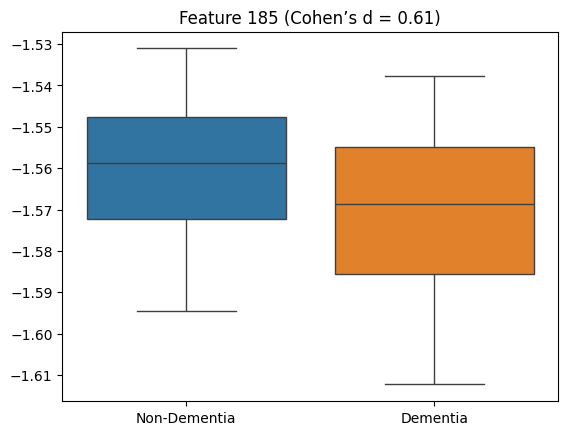

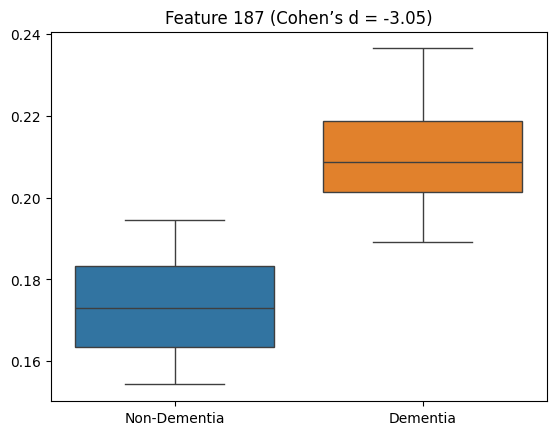

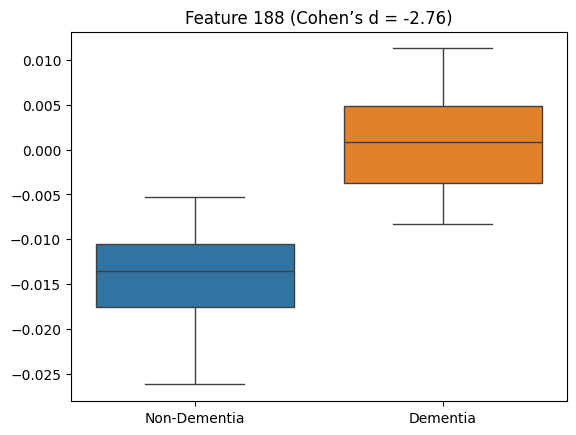

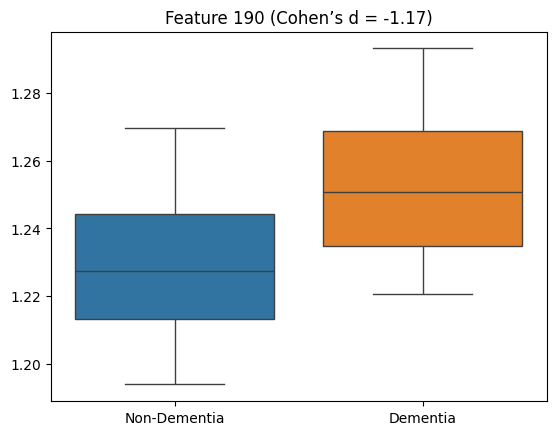

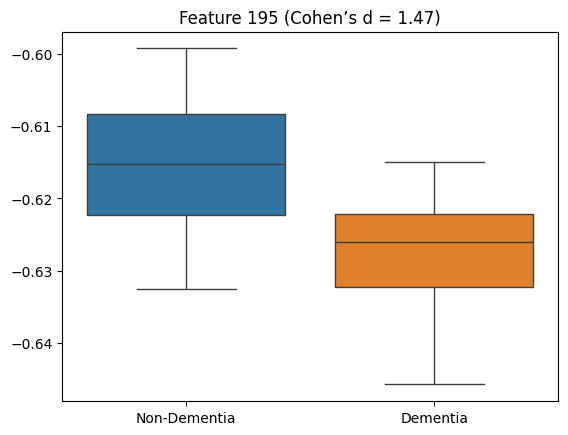

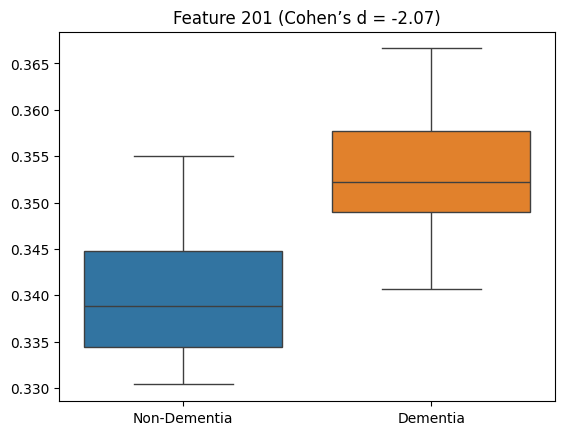

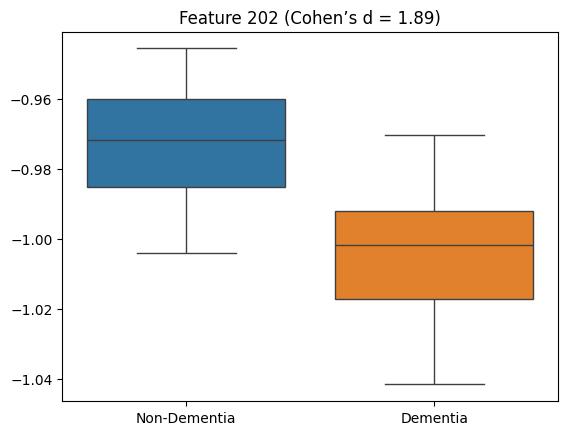

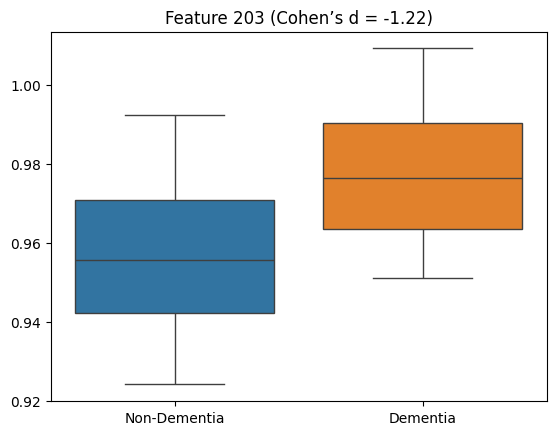

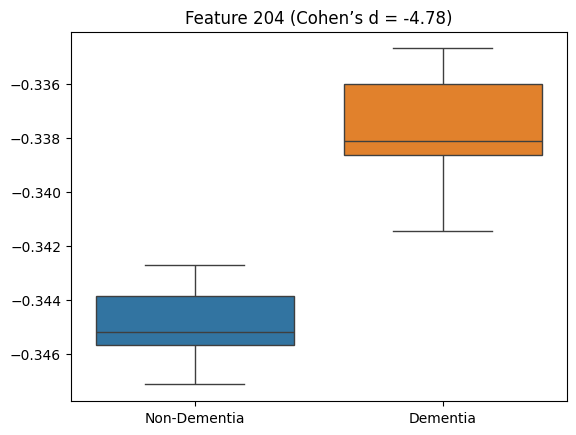

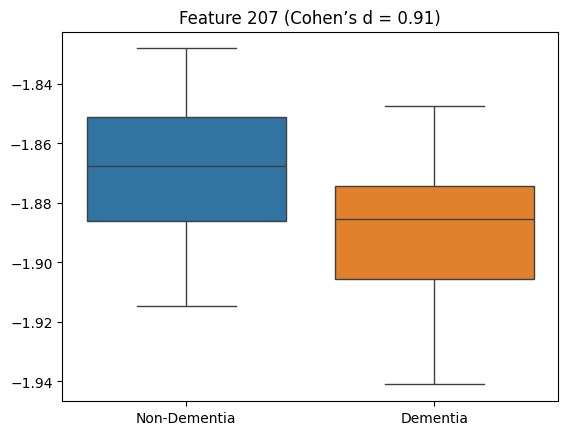

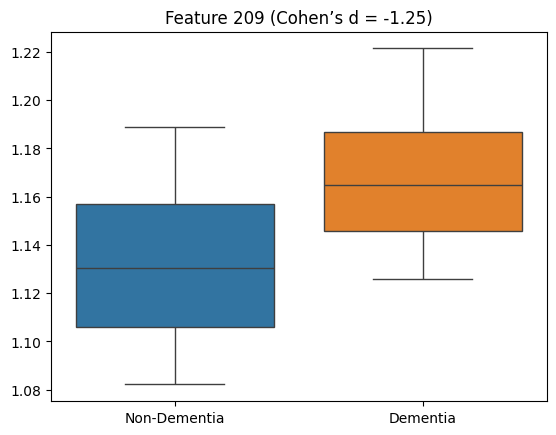

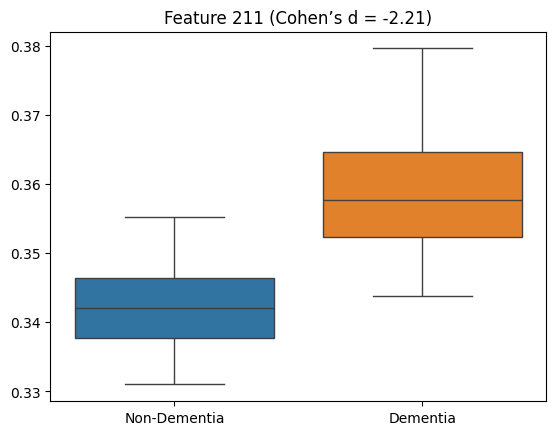

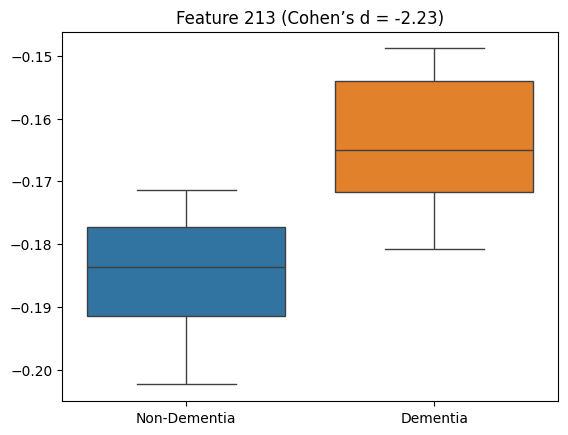

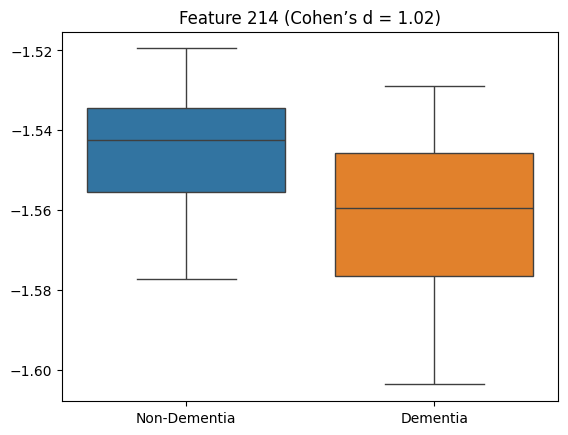

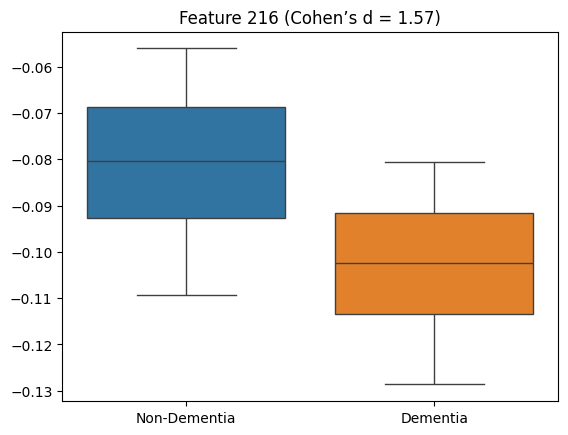

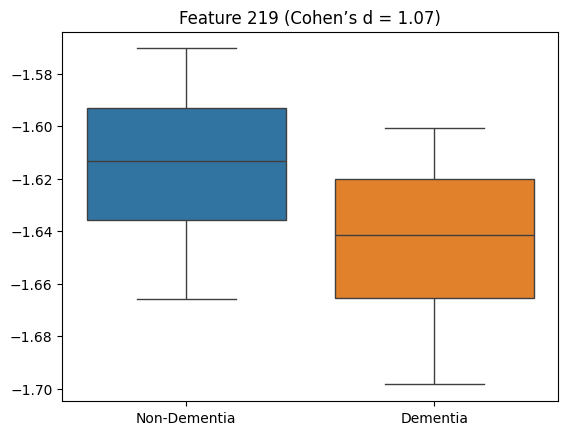

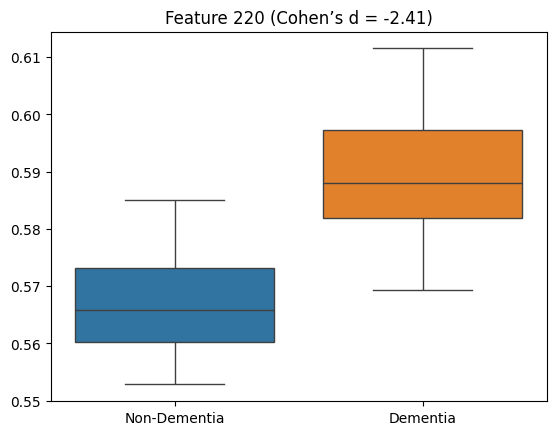

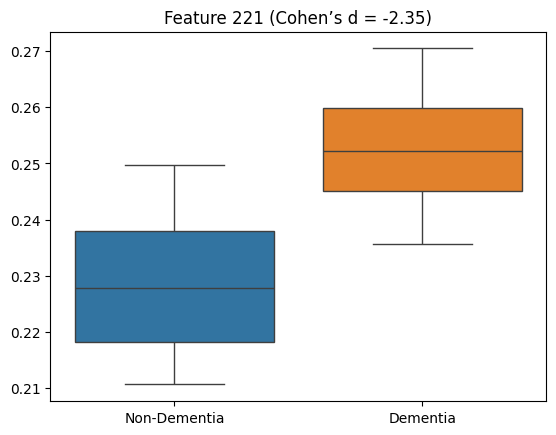

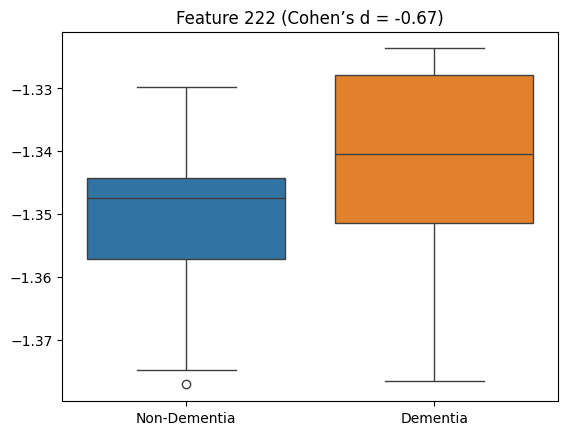

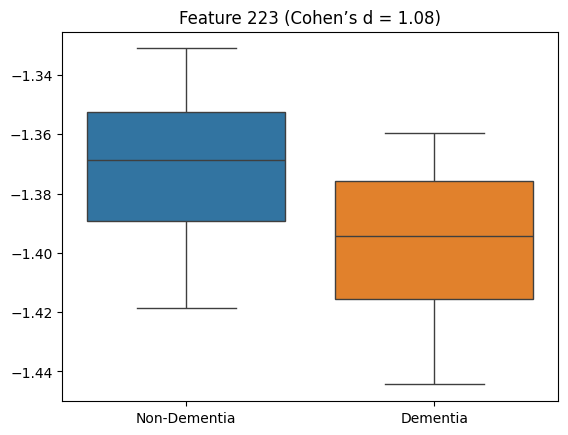

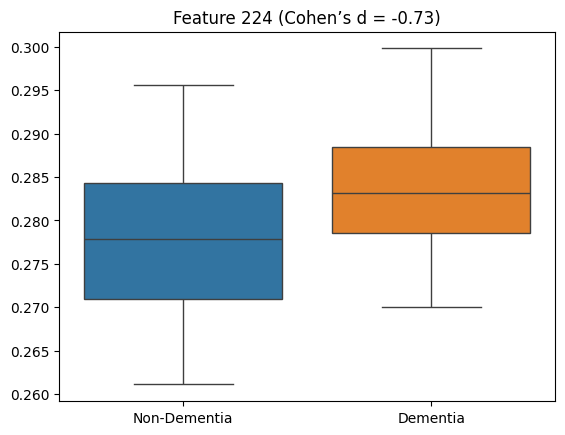

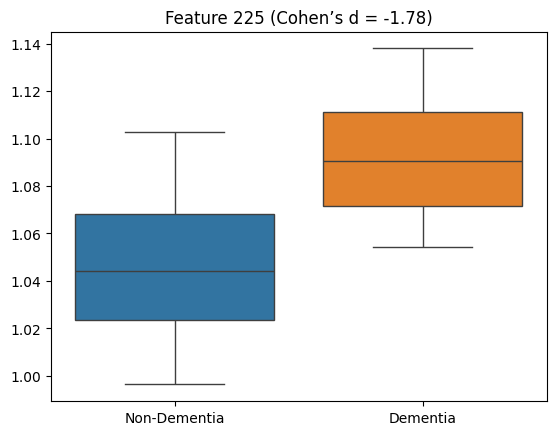

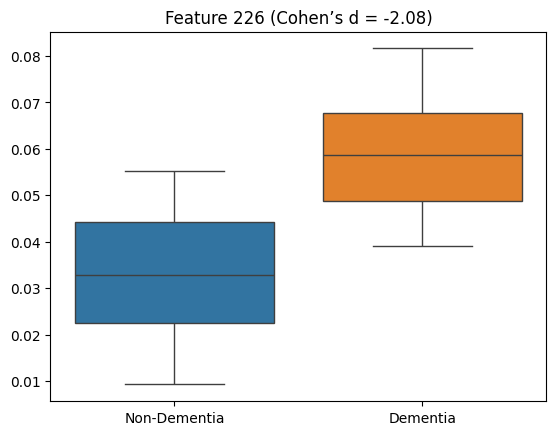

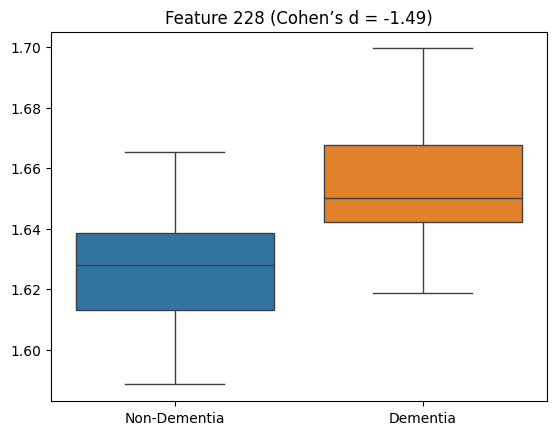

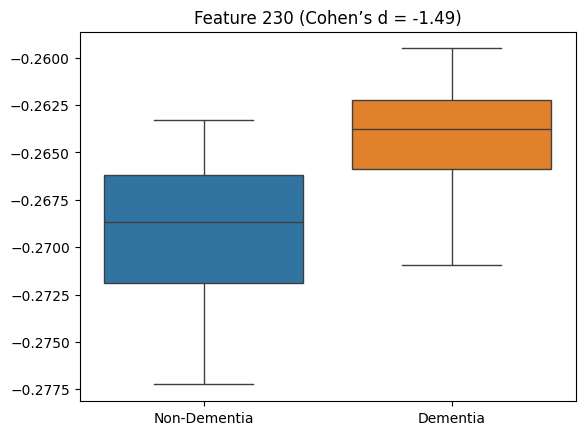

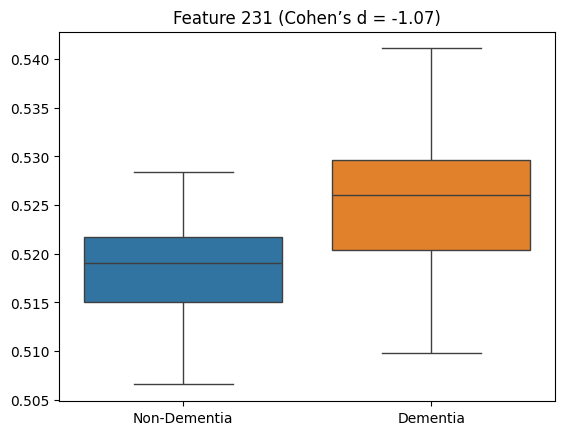

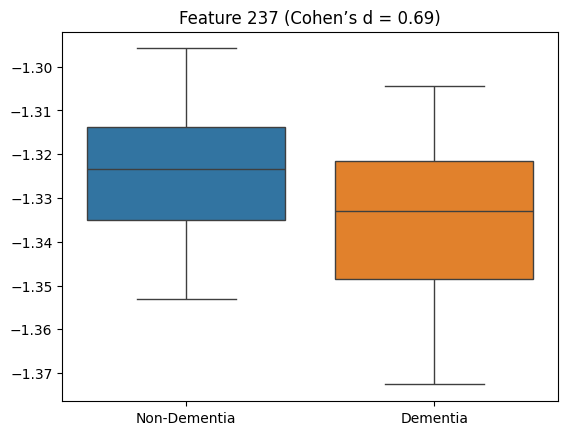

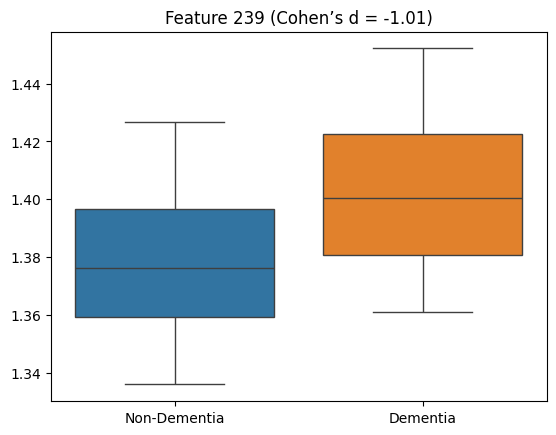

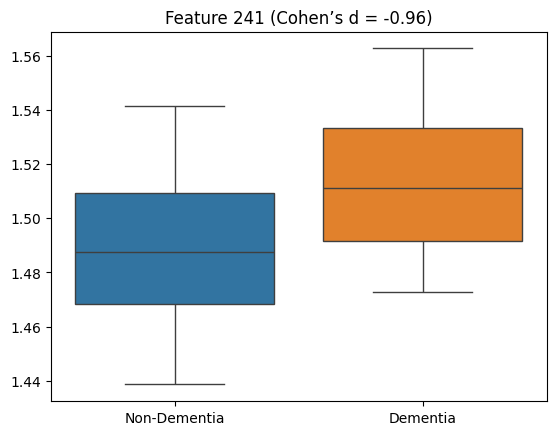

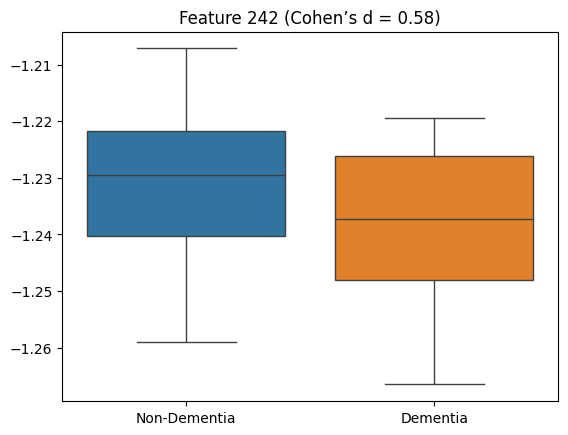

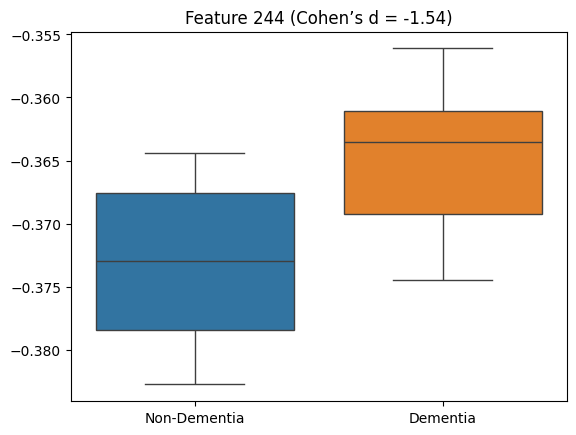

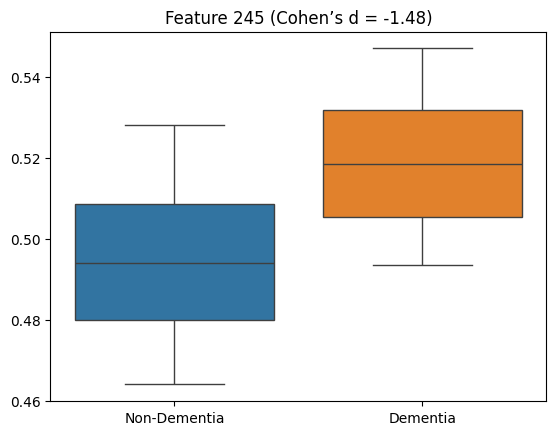

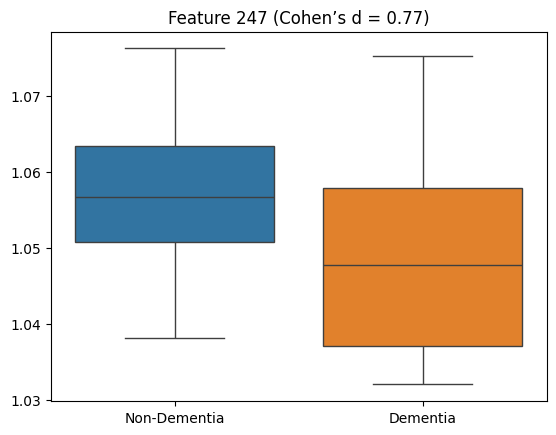

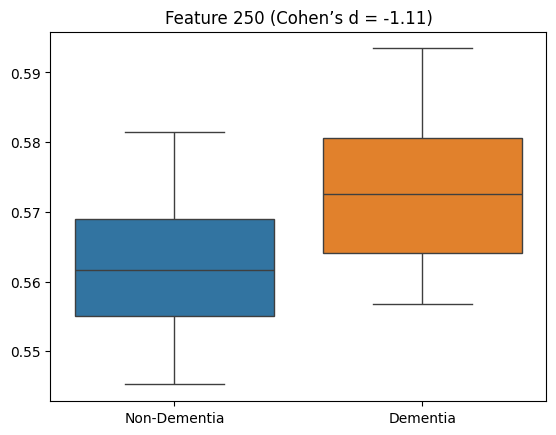

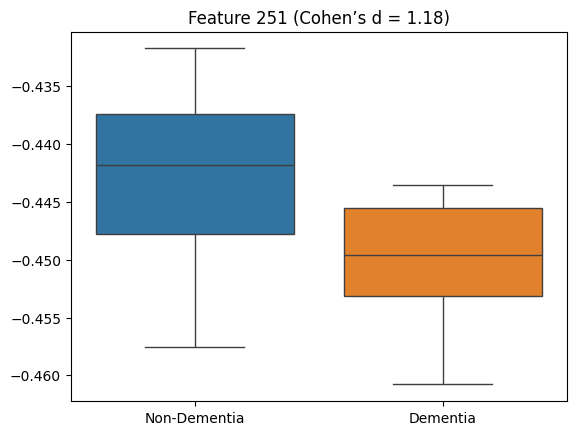

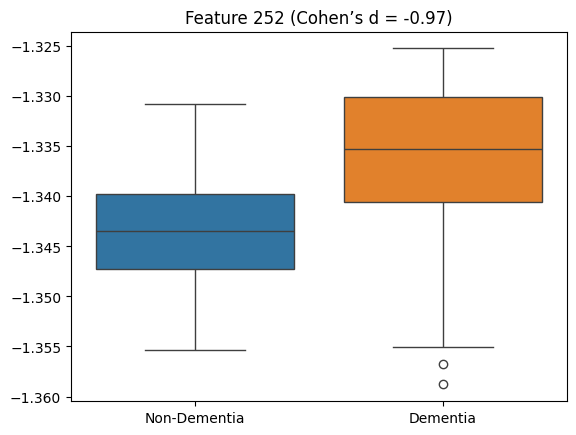

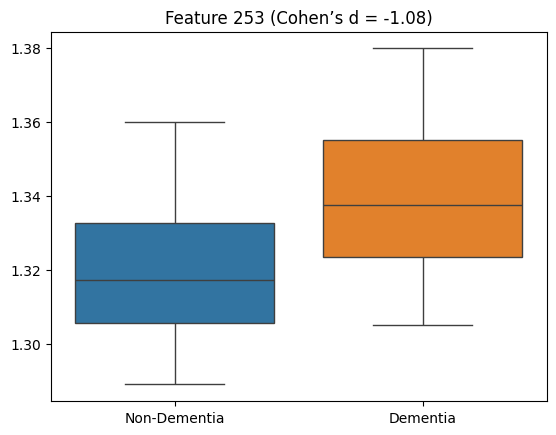

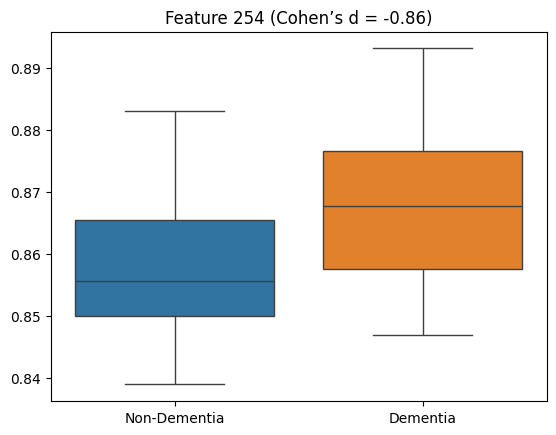

In [10]:
# Assuming:
# non_dementia_data: shape (84, 256)
# dementia_data: shape (84, 256)
# normal_equal_variance_idx = Indexes of normal features with equal variance suitable for Student T-Test (e.g., [0, 5, 12])

def cohens_d(group1, group2):
    # Calculate Cohen's d for effect size
    diff = np.mean(group1) - np.mean(group2)
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1)*var1 + (n2 - 1)*var2) / (n1 + n2 - 2))
    return diff / pooled_std


# Initialize storage for results
p_values = []
cohen_d_values = []

# Loop through each normal feature index
for feature_idx in normal_equal_variance_idx:
    # Perform Student’s t-test (equal variances)
    t_stat, p = ttest_ind(outputs_CN[:, feature_idx].cpu(),
                          outputs_AD[:, feature_idx].cpu(),
                          equal_var=True)
    p_values.append(p)

    # Calculate Cohen’s d
    d = cohens_d(outputs_CN[:, feature_idx].cpu().numpy(),
                 outputs_AD[:, feature_idx].cpu().numpy())
    cohen_d_values.append(d)

# Apply Bonferroni correction for multiple comparisons
alpha = 0.05
reject_null, corrected_p_values, _, _ = multipletests(
    pvals=p_values,
    alpha=alpha,
    method='bonferroni'
)

# Directory to save the histograms
save_dir = "histograms/student t test/significant_features/"
os.makedirs(save_dir, exist_ok=True)

# Print results
print("Significant Features After Bonferroni Correction:")
for i, feature_idx in enumerate(normal_equal_variance_idx):
    if corrected_p_values[i] < alpha:
        print(f"Feature {feature_idx + 1}:")
        print(f"  - Adjusted p-value = {corrected_p_values[i]:.6f}")
        print(f"  - Cohen’s d = {cohen_d_values[i]:.3f} (effect size)")

# Optional: Plot distributions of significant features

for i, feature_idx in enumerate(normal_equal_variance_idx):
    if corrected_p_values[i] < alpha:
        plt.figure()
        sns.boxplot(data=[outputs_CN[:, feature_idx].cpu().numpy(),
                    outputs_AD[:, feature_idx].cpu().numpy()])
        plt.xticks([0, 1], ['Non-Dementia', 'Dementia'])
        plt.title(
            f"Feature {feature_idx} (Cohen’s d = {cohen_d_values[i]:.2f})")
        plt.savefig(os.path.join(
            save_dir, f"{feature_idx:03d}.png"), dpi=300, bbox_inches='tight')
        plt.show()

### Mann-Whitney U Test

In [16]:
print(f"Number of non-normal features: {len(non_normal_feature_idx)}")
print(f"Number of normal features: {len(normal_feature_idx)}")

Number of non-normal features: 33
Number of normal features: 223


#### For All (assuming normality test isn't accurate)

In [17]:
p_values = []
for feature_idx in range(outputs_CN.size(1)):
    _, p = mannwhitneyu(
        outputs_CN[:, feature_idx].cpu(),
        outputs_AD[:, feature_idx].cpu(),
        alternative='two-sided'
    )
    p_values.append(p)

# Apply Bonferroni correction
alpha = 0.05
reject_null, corrected_p_values, _, _ = multipletests(
    pvals=p_values,
    alpha=alpha,
    method='bonferroni'
)

# Print significant features
significant_features_idxs = np.where(reject_null)[0]
print(
    f"Significant features after Bonferroni correction (alpha={alpha}): {significant_features_idxs}")

# Print raw and corrected p-values for inspection
for idx, (p_raw, p_adj) in enumerate(zip(p_values, corrected_p_values)):
    print(f"Feature {idx + 1}: Raw p = {p_raw:.6f}, Adjusted p = {p_adj:.6f}")

Significant features after Bonferroni correction (alpha=0.05): [  0   2   4   5  11  13  14  15  18  20  21  22  26  27  28  35  36  40
  41  42  44  45  51  53  54  55  59  66  67  68  69  70  72  74  78  82
  83  84  86  89  90  91  94  97  99 101 103 104 105 107 109 110 114 115
 120 121 122 123 126 129 131 132 133 134 135 136 139 142 143 144 145 146
 147 148 149 150 151 153 154 155 158 159 160 163 164 165 168 169 171 172
 173 175 178 179 181 182 183 184 186 187 188 190 191 192 194 195 196 199
 201 202 203 204 205 206 207 209 211 212 213 214 215 216 218 219 220 221
 222 223 224 225 226 228 229 230 231 237 238 239 241 243 244 245 246 247
 248 250 251 252 253 254]
Feature 1: Raw p = 0.000004, Adjusted p = 0.001042
Feature 2: Raw p = 0.001193, Adjusted p = 0.305505
Feature 3: Raw p = 0.000000, Adjusted p = 0.000021
Feature 4: Raw p = 0.003192, Adjusted p = 0.817168
Feature 5: Raw p = 0.000000, Adjusted p = 0.000004
Feature 6: Raw p = 0.000000, Adjusted p = 0.000000
Feature 7: Raw p = 0.

In [18]:
significant_features_idxs.shape

(150,)

## Question 2

In [19]:
outputs_AD.size()

torch.Size([84, 256])

In [20]:
torch.max(outputs_AD, dim=0)[0] - torch.min(outputs_AD, dim=0)[0]

tensor([0.1350, 0.0924, 0.0765, 0.1383, 0.1300, 0.1316, 0.0732, 0.0920, 0.0994,
        0.1091, 0.1119, 0.1507, 0.0802, 0.1053, 0.1077, 0.1223, 0.0924, 0.1185,
        0.1464, 0.0950, 0.1373, 0.1446, 0.0865, 0.0809, 0.0933, 0.1231, 0.1236,
        0.1111, 0.1127, 0.0759, 0.0872, 0.1166, 0.1049, 0.1161, 0.1030, 0.0100,
        0.1260, 0.0959, 0.1215, 0.1041, 0.0604, 0.1480, 0.1182, 0.0870, 0.1439,
        0.1137, 0.0899, 0.1380, 0.0965, 0.1275, 0.0987, 0.1246, 0.1094, 0.1319,
        0.1062, 0.1205, 0.1307, 0.1133, 0.1119, 0.0712, 0.1192, 0.1088, 0.1043,
        0.1091, 0.1063, 0.1040, 0.1189, 0.1075, 0.1273, 0.0548, 0.1289, 0.1310,
        0.1290, 0.1018, 0.1248, 0.1227, 0.1158, 0.0953, 0.1274, 0.1235, 0.0855,
        0.1110, 0.0876, 0.1382, 0.1434, 0.1062, 0.1621, 0.0535, 0.0764, 0.0848,
        0.1160, 0.1157, 0.1354, 0.1204, 0.0179, 0.1058, 0.1138, 0.0879, 0.0594,
        0.1255, 0.0256, 0.1240, 0.0988, 0.1499, 0.1364, 0.1367, 0.0962, 0.1377,
        0.1186, 0.1180, 0.1619, 0.1154, 

In [21]:
merged_output = torch.cat((outputs_CN, outputs_AD), dim=0)
merged_output.size()

torch.Size([168, 256])

### Laura, focus on visualization of this cell, everything about calculation is correct, just focus on visualization of this cell

/tmp/ipykernel_3740/60223574.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


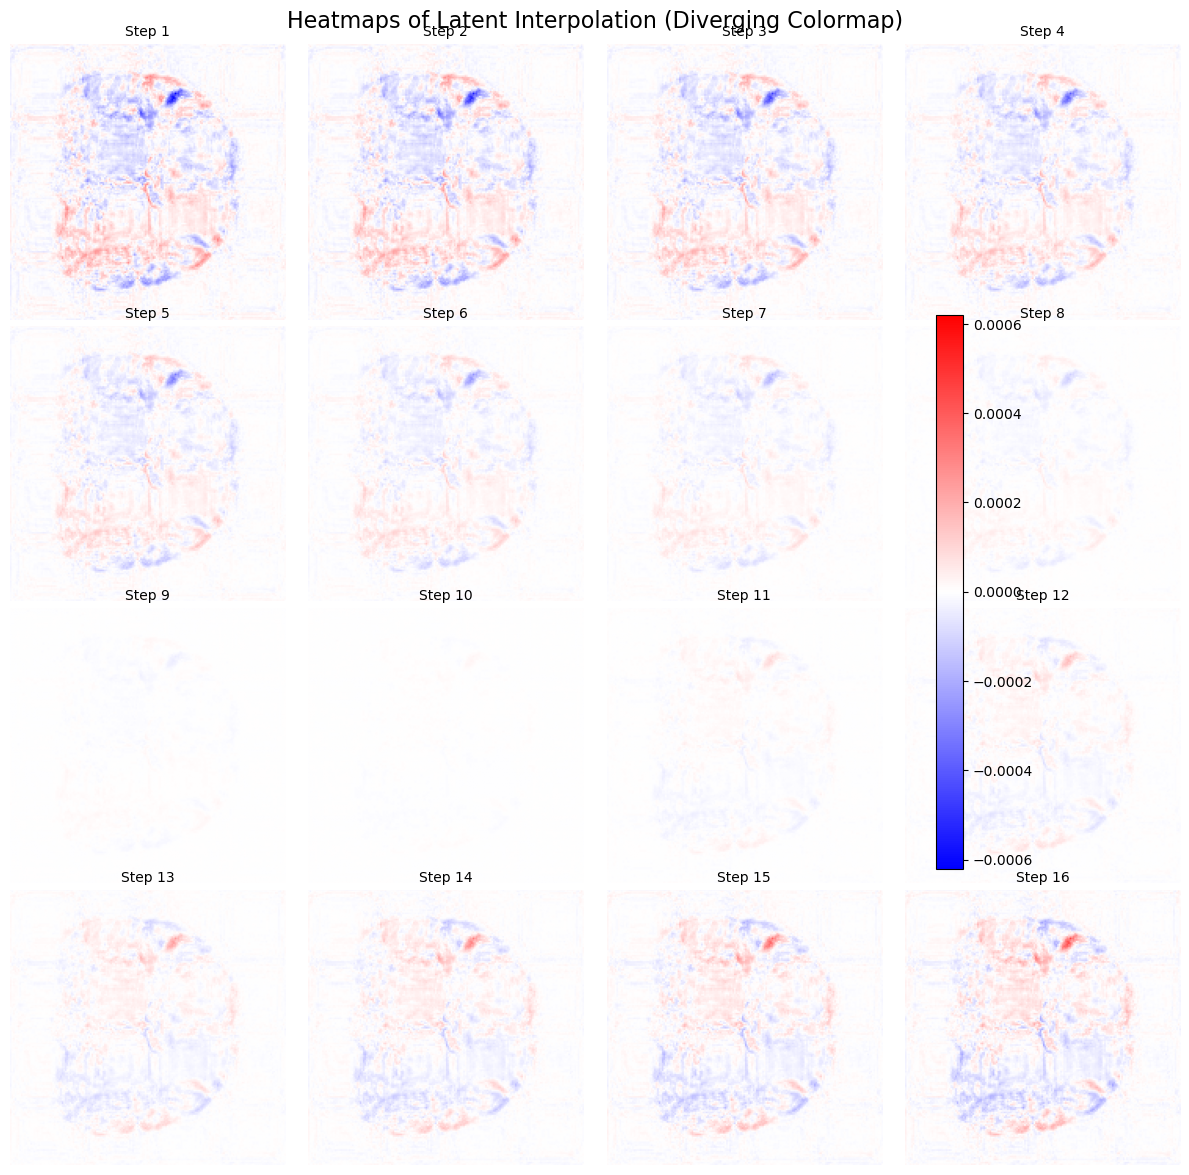

In [23]:
# mu_prior = mu_logvar_prior[:, self.hparams.dim_latent_space:]

merged_output = merged_output[:, 128:]

# 1. Compute the mean latent vector (central latent)
mean_latent = merged_output.mean(dim=0)  # Shape: (latent_dim,)

# 2. Choose a latent dimension to interpolate (e.g., index 153)
feature_idx = 153 - 128  # Adjust for the 128 dimensions removed

# Compute the min and max for this latent dimension
feature_min = merged_output[:, feature_idx].min()
feature_max = merged_output[:, feature_idx].max()


# Define number of interpolation steps
num_steps = 16

# Create linearly spaced values over the observed range
feature_values = torch.linspace(feature_min, feature_max, steps=num_steps)

# 3. Generate latent vectors by copying the mean latent vector
#    and modifying only the chosen feature
interpolated_latents = mean_latent.unsqueeze(0).repeat(
    num_steps, 1)  # Shape: (num_steps, latent_dim)
interpolated_latents[:, feature_idx] = feature_values

# 4. Decode the interpolated latent vectors to generate images
# Shape: (num_steps, channels, H, W)
decoder = model.decoder
with torch.no_grad():
    generated_images = decoder(interpolated_latents)
    # Decode the central (mean) latent vector to get the reference image
    # Shape: (1, channels, H, W)
    central_image = decoder(mean_latent.unsqueeze(0))

# 5. Compute the difference images (heatmaps) by subtracting the central image
# Broadcasting central_image to each generated image in the batch.
difference_images = generated_images - central_image

# 6. Set up a diverging colormap with symmetric limits around zero
# Compute the maximum absolute difference for symmetric scaling
global_diff_min = difference_images.min().item()
global_diff_max = difference_images.max().item()
abs_max = max(abs(global_diff_min), abs(global_diff_max))

# Choose a diverging colormap (e.g., 'bwr' for blue-white-red)
diverging_cmap = 'bwr'

# 7. Plot all the difference images in a single grid.
num_rows, num_cols = 4, 4  # For 16 images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, ax in enumerate(axes.flatten()):
    heatmap = difference_images[idx, 0].detach().cpu()
    im = ax.imshow(heatmap, cmap=diverging_cmap, vmin=-abs_max, vmax=abs_max)
    ax.set_title(f'Step {idx+1}', fontsize=10)
    ax.axis('off')

# Add a colorbar to the plot
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
fig.suptitle(
    "Heatmaps of Latent Interpolation (Diverging Colormap)", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# --- [Your existing code above remains unchanged] ---
# 1. Compute the mean latent vector (central latent)
import matplotlib.pyplot as plt
import numpy as np
mean_latent = merged_output.mean(dim=0)  # Shape: (latent_dim,)

# 2. Choose a latent dimension to interpolate (e.g., index 153)
feature_idx = 153 - 128  # Adjust for the 128 dimensions removed

# Compute the min and max for this latent dimension
feature_min = merged_output[:, feature_idx].min()
feature_max = merged_output[:, feature_idx].max()

# Define number of interpolation steps
num_steps = 16

# Create linearly spaced values over the observed range
feature_values = torch.linspace(feature_min, feature_max, steps=num_steps)

# 3. Generate latent vectors by copying the mean latent vector
#    and modifying only the chosen feature
interpolated_latents = mean_latent.unsqueeze(0).repeat(
    num_steps, 1)  # Shape: (num_steps, latent_dim)
interpolated_latents[:, feature_idx] = feature_values

# 4. Decode the interpolated latent vectors to generate images
decoder = model.decoder
with torch.no_grad():
    # Shape: (num_steps, channels, H, W)
    generated_images = decoder(interpolated_latents)
    # Decode the central (mean) latent vector to get the reference image
    # Shape: (1, channels, H, W)
    central_image = decoder(mean_latent.unsqueeze(0))

# 5. Compute the difference images (heatmaps) by subtracting the central image
difference_images = generated_images - central_image

# --- Updated Plotting Section ---
# Convert decoded images and central image to numpy arrays for visualization.
decoded_images_np = generated_images.cpu().numpy()
# Use the central image (decoded from the mean latent) as the reference.
reference_image_np = central_image.cpu().numpy()[0]  # remove batch dimension
# Compute difference images relative to the reference image.
difference_images_np = decoded_images_np - reference_image_np

# Compute the maximum absolute difference for symmetric scaling.
global_diff_min = difference_images_np.min()
global_diff_max = difference_images_np.max()
abs_max = max(abs(global_diff_min), abs(global_diff_max))

# For plotting, split the images into two groups.
n_cols = num_steps // 2  # e.g., for 16 steps, 8 columns per group.
# Two rows for Group 1 (decoded and diff), two for Group 2.
n_rows = 4


fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Group 1: indices 0 to n_cols-1
for idx in range(n_cols):
    # Row 0: Plot decoded image.
    ax = axes[0, idx]
    img = decoded_images_np[idx]
    if img.shape[0] == 1:
        img = np.squeeze(img, axis=0)
    ax.imshow(img, cmap='gray')
    ax.set_title(
        f"Latent {feature_idx+128} = {feature_values[idx].item():.2f}", fontsize=8)
    ax.axis('off')

    # Row 1: Plot difference image.
    ax = axes[1, idx]
    diff = difference_images_np[idx]
    if diff.shape[0] == 1:
        diff = np.squeeze(diff, axis=0)
    im = ax.imshow(diff, cmap='seismic', vmin=-abs_max, vmax=abs_max)
    ax.set_title(f"Diff: {feature_values[idx].item():.2f}", fontsize=8)
    ax.axis('off')

# Group 2: indices n_cols to num_steps-1
for idx in range(n_cols, num_steps):
    col = idx - n_cols  # Map to column index 0 ... n_cols-1
    # Row 2: Plot decoded image.
    ax = axes[2, col]
    img = decoded_images_np[idx]
    if img.shape[0] == 1:
        img = np.squeeze(img, axis=0)
    ax.imshow(img, cmap='gray')
    ax.set_title(
        f"Latent {feature_idx+128} = {feature_values[idx].item():.2f}", fontsize=8)
    ax.axis('off')

    # Row 3: Plot difference image.
    ax = axes[3, col]
    diff = difference_images_np[idx]
    if diff.shape[0] == 1:
        diff = np.squeeze(diff, axis=0)
    im = ax.imshow(diff, cmap='seismic', vmin=-abs_max, vmax=abs_max)
    ax.set_title(f"Diff: {feature_values[idx].item():.2f}", fontsize=8)
    ax.axis('off')

# Adjust layout to leave space for a horizontal colorbar.
plt.subplots_adjust(bottom=0.15)
cb_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
fig.colorbar(im, cax=cb_ax, orientation='horizontal')
fig.suptitle(
    "Heatmaps of Latent Interpolation (Diverging Colormap)", fontsize=16)
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x256 and 128x8192)

: 

In [24]:
i = 153

max_CN = torch.max(outputs_CN, dim=0)[0]
min_CN = torch.min(outputs_CN, dim=0)[0]

max_AD = torch.max(outputs_AD, dim=0)[0]
min_AD = torch.min(outputs_AD, dim=0)[0]

# Number of interpolation steps and the range for the selected dimension.
num_steps = 10
latent_range = torch.linspace(min_i, max_i, num_steps)

# Get the latent space dimension from your model's hyperparameters.
dim_latent = model.hparams.dim_latent_space

# Create a "central" latent vector (all zeros).
central_latent = torch.zeros((1, dim_latent), dtype=torch.float32)

# Create a list to store the interpolated latent vectors.
latent_vectors = []
for val in latent_range:
    vec = central_latent.clone()  # copy the central vector
    # set the i-th dimension to the interpolated value
    vec[0, i] = val
    latent_vectors.append(vec)

# Stack into one tensor of shape (num_steps, dim_latent)
latent_vectors = torch.cat(latent_vectors, dim=0)

# Decode these latent vectors using the model's decoder.
with torch.no_grad():
    decoded_images = model.decoder(latent_vectors)
    # decoded_images shape: (num_steps, C, H, W)

# Convert decoded images to numpy arrays for visualization.
decoded_images_np = decoded_images.cpu().numpy()

# Use the middle decoded image as the reference image.
middle_index = num_steps // 2  # For num_steps=10, this gives index 5.
reference_image_np = decoded_images_np[middle_index]

# Compute difference images relative to the reference image.
difference_images = decoded_images_np - reference_image_np

# --- Plotting ---
# We'll display 10 interpolated images split into 2 groups:
#   Group 1: indices 0-4  --> row 1: decoded, row 2: diff
#   Group 2: indices 5-9  --> row 3: decoded, row 4: diff
n_cols = 5
n_rows = 4  # 4 rows total

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

# Group 1 (indices 0 to 4)
for idx in range(5):
    # Row 1: Decoded image.
    ax = axes[0, idx]
    img = decoded_images_np[idx]
    if img.shape[0] == 1:
        img = np.squeeze(img, axis=0)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Latent {i} = {latent_range[idx]:.2f}", fontsize=8)
    ax.axis('off')

    # Row 2: Difference image.
    ax = axes[1, idx]
    diff = difference_images[idx]
    if diff.shape[0] == 1:
        diff = np.squeeze(diff, axis=0)
    im = ax.imshow(diff, cmap='seismic')
    ax.set_title(f"Diff: {latent_range[idx]:.2f}", fontsize=8)
    ax.axis('off')

# Group 2 (indices 5 to 9)
for idx in range(5, 10):
    col = idx - 5  # map indices 5-9 to columns 0-4
    # Row 3: Decoded image.
    ax = axes[2, col]
    img = decoded_images_np[idx]
    if img.shape[0] == 1:
        img = np.squeeze(img, axis=0)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Latent {i} = {latent_range[idx]:.2f}", fontsize=8)
    ax.axis('off')

    # Row 4: Difference image.
    ax = axes[3, col]
    diff = difference_images[idx]
    if diff.shape[0] == 1:
        diff = np.squeeze(diff, axis=0)
    im = ax.imshow(diff, cmap='seismic')
    ax.set_title(f"Diff: {latent_range[idx]:.2f}", fontsize=8)
    ax.axis('off')

# Adjust layout to leave space at the bottom for the colorbar.
plt.subplots_adjust(bottom=0.15)

# Add a horizontal colorbar below all rows (using the last plotted image handle 'im').
cb_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
fig.colorbar(im, cax=cb_ax, orientation='horizontal')

plt.show()

NameError: name 'min_i' is not defined

## Question 4
Interpreting the features with the use of volumetric measures of brain regions of interest (which are available in the dataset) - which regions are affected by a given feature?

In [26]:
metadata1 = pd.read_csv(
    "adni.csv")
metadata1

PTID                     SEQUENCE            DatePostfix  \
0      011_S_4366                       MPRAGE  2012-01-31_10_06_03.0   
1      011_S_4366                       MPRAGE  2012-11-08_07_38_16.0   
2      011_S_4366                       MPRAGE  2011-11-14_15_42_54.0   
3      011_S_4366                       MPRAGE  2012-04-04_08_38_27.0   
4      011_S_4366               MPRAGE_GRAPPA2  2012-01-31_10_11_41.0   
...           ...                          ...                    ...   
12784  168_S_6426  Accelerated_Sagittal_MPRAGE  2019-10-16_14_37_01.0   
12785  012_S_1292                   MPRAGEadni  2008-03-25_16_18_34.0   
12786  012_S_1292                   MPRAGEadni  2008-09-22_15_22_04.0   
12787  012_S_1292                   MPRAGEadni  2008-09-22_15_33_45.0   
12788  012_S_1292                   MPRAGEadni  2008-03-25_16_06_43.0   

      SERIESID                                  filepath_debiased  \
0      S138953  /dhc/groups/fglippert/adni_t1_mprage/011_S_436...   
1      S173811  /dhc/groups/fglippert/adni_t1_mprage/011_S_436...   
2      S129365  /dhc/groups/fglippert/adni_t1_mprage/011_S_436...   
3      S145976  /dhc/groups/fglippert/adni_t1_mprage/011_S_436...   
4      S138956  /dhc/groups/fglippert/adni_t1_mprage/011_S_436...   
...        ...                                                ...   
12784  S884708  /dhc/groups/fglippert/adni_t1_mprage/168_S_642...   
12785   S47696  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...   
12786   S56678  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...   
12787   S56679  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...   
12788   S47695  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...   

                                            filepath_MNI    EXAMDATE  \
0      /dhc/groups/fglippert/adni_t1_mprage/011_S_436...  2012-01-31   
1      /dhc/groups/fglippert/adni_t1_mprage/011_S_436...  2012-11-08   
2      /dhc/groups/fglippert/adni_t1_mprage/011_S_436...  2011-11-14   
3      /dhc/groups/fglippert/adni_t1_mprage/011_S_436...  2012-04-04   
4      /dhc/groups/fglippert/adni_t1_mprage/011_S_436...  2012-01-31   
...                                                  ...         ...   
12784  /dhc/groups/fglippert/adni_t1_mprage/168_S_642...  2019-10-16   
12785  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...  2008-03-25   
12786  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...  2008-09-22   
12787  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...  2008-09-22   
12788  /dhc/groups/fglippert/adni_t1_mprage/012_S_129...  2008-03-25   

       MAGSTRENGTH_x   STUDYID  IMAGEUID_x  ...  right amygdala  \
0                3.0   42273.0    281570.0  ...        2049.021   
1                3.0   54301.0    345565.0  ...        1942.525   
2                3.0   39724.0    266564.0  ...        2054.450   
3                3.0   44286.0    295390.0  ...        2079.368   
4                3.0   42273.0    281574.0  ...        1982.485   
...              ...       ...         ...  ...             ...   
12784            3.0  143682.0   1241416.0  ...        2222.643   
12785            3.0   15228.0     99897.0  ...        2096.109   
12786            3.0   17786.0    118342.0  ...        2134.395   
12787            3.0   17786.0    118343.0  ...        2087.647   
12788            3.0   15228.0     99896.0  ...        1916.084   

       right accumbens area  right ventral DC ABETA_gt_1200  \
0                   774.720          5265.106         False   
1                   733.348          5167.854         False   
2                   763.825          5233.430         False   
3                   733.413          5213.208         False   
4                   814.540          5265.210         False   
...                     ...               ...           ...   
12784               834.367          5523.287           NaN   
12785               706.347          5016.530         False   
12786               665.171          5078.542         False   
12787  

In [27]:
channel_names = "left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,left putamen,left pallidum,3rd ventricle,4th ventricle,brain-stem,left hippocampus,left amygdala,left accumbens area,left ventral DC,right cerebral white matter,right cerebral cortex,right lateral ventricle,right inferior lateral ventricle,right cerebellum white matter,right cerebellum cortex,right thalamus,right caudate,right putamen,right pallidum,right hippocampus,right amygdala,right accumbens area,right ventral DC,total intracranial,csf,lateral ventricle,cerebral white matter,cerebellum white matter,white matter"
channel_names = channel_names.split(",")
len(channel_names)

37

In [28]:
metadata1[channel_names]

left cerebral white matter  left cerebral cortex  \
0                       225804.44             254519.88   
1                       218980.56             246567.81   
2                       228237.34             253656.02   
3                       224148.70             246610.98   
4                       226476.00             255915.62   
...                           ...                   ...   
12784                   279081.03             335182.03   
12785                   236790.40             249178.06   
12786                   242293.88             251753.89   
12787                   238302.66             254070.11   
12788                   236551.83             262205.78   

       left lateral ventricle  left inferior lateral ventricle  \
0                   16991.330                         1924.511   
1                   17184.758                         2011.423   
2                   16858.190                         1784.597   
3                   17106.533                         1816.919   
4                   16980.510                         1780.018   
...                       ...                              ...   
12784               10780.017                          515.175   
12785               15149.377                         1258.568   
12786               15679.364                         1174.839   
12787               15558.685                         1202.096   
12788               15474.814                         1238.808   

       left cerebellum white matter  left cerebellum cortex  left thalamus  \
0                         18136.035               58650.855       6997.488   
1                         17630.193               58016.336       6464.177   
2                         17290.422               56905.910       7117.142   
3                         18077.643               57125.598       6803.706   
4                         17554.764               57028.160       6997.766   
...                             ...                     ...            ...   
12784                     21469.586               68645.484       9974.298   
12785                     19451.586               62180.125       8635.444   
12786                     20204.700               62889.950       7935.219   
12787                     19509.412               63579.613       8404.297   
12788                     20656.342               62322.836       8897.124   

       left caudate  left putamen  left pallidum  ...  right hippocampus  \
0          2896.172      6886.227       1926.968  ...           4039.208   
1          2809.712      6703.410       1862.205  ...           3796.559   
2          2946.598      6622.951       1944.651  ...           4063.118   
3          3008.442      6841.850       2005.724  ...           3972.067   
4          2929.165      6963.170       1885.214  ...           4027.636   
...             ...           ...            ...  ...                ...   
12784      4408.032      7445.150       2339.703  ...           5652.019   
12785      3597.685      6903.150       2290.124  ...           4063.828   
12786      3472.022      6968.581       2234.588  ...           3916.524   
12787      3330.596      7047.963       2340.176  ...           4007.136   
12788      3526.757      7101.706       2293.756  ...           4117.903   

       right amygdala  right accumbens area  right ventral DC  \
0            2049.021               774.720          5265.106   
1            1942.525               733.348          5167.854   
2            2054.450               763.825          5233.430   
3            2079.368               733.413          5213.208   
4            1982.485               814.540          5265.210   
...               ...                   ...               ...   
12784        2222.643               834.367          5523.287   
12785        2096.109               706.347          5016.530   
12786        2134.395               665.171          5078.542   
12787

Interpreting the features with the use of volumetric measures of brain regions of interest (which are available in the dataset) - which regions are affected by a given feature?
the simplest thing to do would be to load the volumes of each participant, and compute a correlation matrix with all the latent dimensions, which would tell you how much hippocampus volume correlates to latent dim 1, latent dim 2, how much do the ventricles correlate, etc.

## Question 6

In [29]:
inputs_CN[:, 2] * max_age

tensor([55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
        69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
        83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96.,
        55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
        69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
        83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96.])

In [31]:
import scipy.stats as stats

# Assume you already have:
# inputs_CN, inputs_AD  of shape [84, 3], columns = [Group(0/1), Sex(0/1), Age]
# outputs_CN, outputs_AD of shape [84, 256]
# These are on GPU; hence the .cpu() calls below.

n_features = outputs_CN.size(1)
p_values_CN = []
p_values_AD = []
corrs_CN = []
corrs_AD = []

# Compute Spearman correlation between each latent feature and Age (column index=2).
for feature_idx in range(n_features):
    corr_CN, p_CN = stats.spearmanr(
        outputs_CN[:, feature_idx].cpu(),
        inputs_CN[:, 2].cpu()*max_age
    )
    corr_AD, p_AD = stats.spearmanr(
        outputs_AD[:, feature_idx].cpu(),
        inputs_AD[:, 2].cpu()
    )
    corrs_CN.append(corr_CN)
    corrs_AD.append(corr_AD)
    p_values_CN.append(p_CN)
    p_values_AD.append(p_AD)

# Bonferroni correction (multiply p-values by number of tests, then clip at 1.0)
adjusted_p_values_CN = [min(p * n_features, 1.0) for p in p_values_CN]
adjusted_p_values_AD = [min(p * n_features, 1.0) for p in p_values_AD]

# Determine which features are significant after Bonferroni
alpha = 0.05
significant_features_CN = [
    i for i, p_adj in enumerate(adjusted_p_values_CN) if p_adj < alpha
]
significant_features_AD = [
    i for i, p_adj in enumerate(adjusted_p_values_AD) if p_adj < alpha
]

print("Significant CN features w.r.t. age:", significant_features_CN)
print("Significant AD features w.r.t. age:", significant_features_AD)

# If you want to print correlation and p-values in a nice table:
for i in range(n_features):
    print(
        f"Feature {i}: CN corr={corrs_CN[i]:.3f}, p_adj={adjusted_p_values_CN[i]:.3e} | "
        f"AD corr={corrs_AD[i]:.3f}, p_adj={adjusted_p_values_AD[i]:.3e}"
    )

Significant CN features w.r.t. age: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 147, 148, 149, 150, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 187, 188, 189, 190, 191, 193, 195, 196, 197, 198, 200, 201, 202, 203, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229

In [32]:
len(significant_features_AD)

241

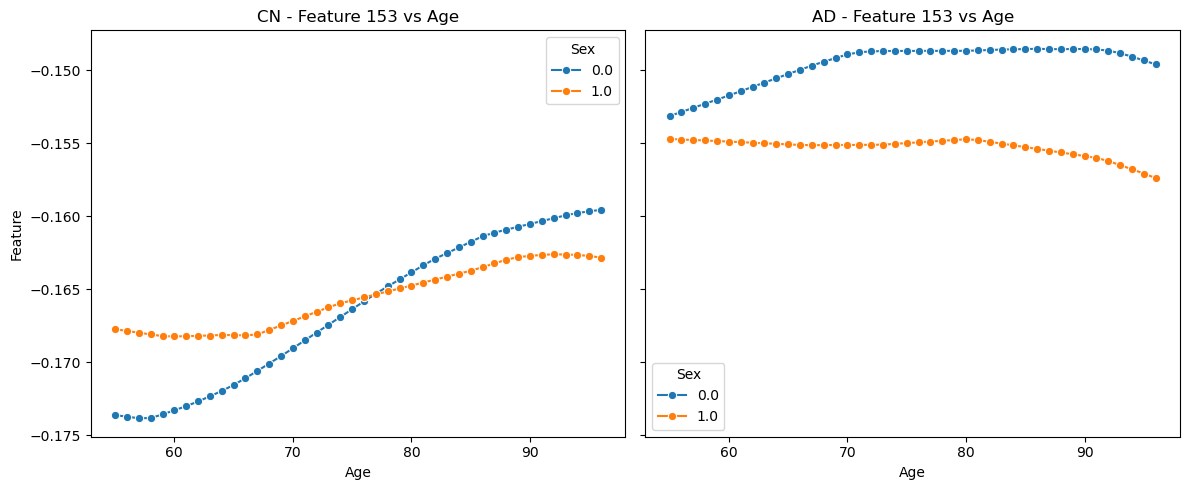

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Let’s pick one feature of interest (e.g., feature_idx = 2)
# or loop through significant ones:
feature_idx = 153  # or any from significant_features_AD / CN

# Prepare data for CN
ages_CN = (inputs_CN[:, 2] * max_age).cpu().numpy()
sex_CN = inputs_CN[:, 1].cpu().numpy()
vals_CN = outputs_CN[:, feature_idx].cpu().numpy()

df_CN = pd.DataFrame({
    "Age": ages_CN,
    "Sex": sex_CN,
    "Feature": vals_CN
})
df_CN["Group"] = "CN"

# Prepare data for AD
ages_AD = (inputs_AD[:, 2] * max_age).cpu().numpy()
sex_AD = inputs_AD[:, 1].cpu().numpy()
vals_AD = outputs_AD[:, feature_idx].cpu().numpy()

df_AD = pd.DataFrame({
    "Age": ages_AD,
    "Sex": sex_AD,
    "Feature": vals_AD
})
df_AD["Group"] = "AD"

# Combine
df_trajectory = pd.concat([df_CN, df_AD], ignore_index=True)

# Plot side by side for CN and AD, coloring by sex if desired
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# CN plot
sns.lineplot(
    ax=axes[0], data=df_trajectory[df_trajectory["Group"] == "CN"],
    x="Age", y="Feature", hue="Sex", marker="o"
)
axes[0].set_title(f"CN - Feature {feature_idx} vs Age")

# AD plot
sns.lineplot(
    ax=axes[1], data=df_trajectory[df_trajectory["Group"] == "AD"],
    x="Age", y="Feature", hue="Sex", marker="o"
)
axes[1].set_title(f"AD - Feature {feature_idx} vs Age")

plt.tight_layout()
plt.show()

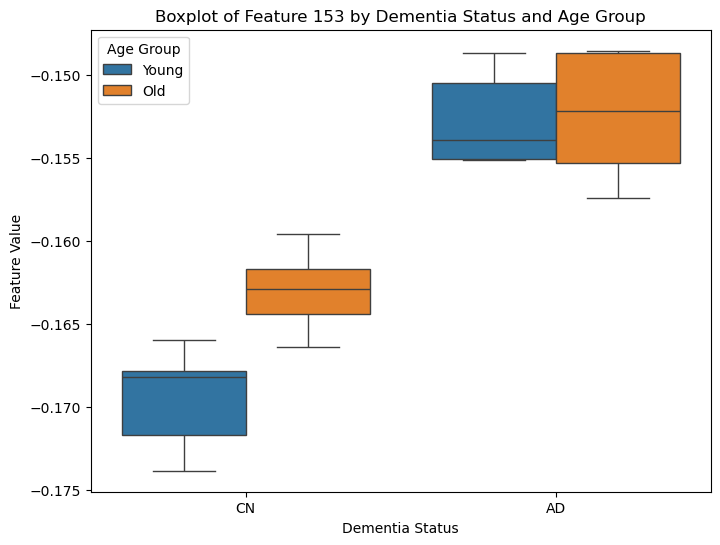

In [34]:
# Define age grouping function (if not defined already)
def age_group(age, threshold=75):
    return "Young" if age < threshold else "Old"


# Build DataFrames for boxplot for CN and AD (ensuring both age groups are present)
df_CN_box = pd.DataFrame({
    "Dementia": "CN",
    "Sex": inputs_CN[:, 1].cpu().numpy(),
    "Age": (inputs_CN[:, 2] * max_age).cpu().numpy(),
    "Feature": outputs_CN[:, feature_idx].cpu().numpy()
})
df_CN_box["AgeGroup"] = df_CN_box["Age"].apply(age_group)

df_AD_box = pd.DataFrame({
    "Dementia": "AD",
    "Sex": inputs_AD[:, 1].cpu().numpy(),
    "Age": (inputs_AD[:, 2] * max_age).cpu().numpy(),
    "Feature": outputs_AD[:, feature_idx].cpu().numpy()
})
df_AD_box["AgeGroup"] = df_AD_box["Age"].apply(age_group)

# Combine into a single DataFrame
df_box = pd.concat([df_CN_box, df_AD_box], ignore_index=True)

# Create a boxplot: x-axis groups by Dementia status (CN vs AD) and hue by AgeGroup (Young vs Old)
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="Dementia", y="Feature", hue="AgeGroup",
    data=df_box, order=["CN", "AD"]
)
plt.title(f"Boxplot of Feature {feature_idx} by Dementia Status and Age Group")
plt.xlabel("Dementia Status")
plt.ylabel("Feature Value")
plt.legend(title="Age Group")
plt.show()

In [35]:
# Directory to save the histograms
save_dir = "histograms/Age Trajectory/"
os.makedirs(save_dir, exist_ok=True)

for feature_idx in range(256):
    # Create DataFrames for CN and AD with an extra column that combines group and sex
    df_CN = pd.DataFrame({
        "Age": (inputs_CN[:, 2] * max_age).cpu().numpy(),
        "Sex": inputs_CN[:, 1].cpu().numpy(),
        "Feature": outputs_CN[:, feature_idx].cpu().numpy(),
        "Group": "CN"
    })
    df_AD = pd.DataFrame({
        "Age": (inputs_AD[:, 2] * max_age).cpu().numpy(),
        "Sex": inputs_AD[:, 1].cpu().numpy(),
        "Feature": outputs_AD[:, feature_idx].cpu().numpy(),
        "Group": "AD"
    })
    df_trajectory = pd.concat([df_CN, df_AD], ignore_index=True)

    # Map sex from numeric to labels for clarity
    df_trajectory["SexLabel"] = df_trajectory["Sex"].map(
        {0: "Male", 1: "Female"})

    # Create a combined column for group and sex (e.g., "CN_Male", "AD_Female")
    df_trajectory["GroupSex"] = df_trajectory["Group"] + \
        "_" + df_trajectory["SexLabel"]

    # Sort by Age if desired
    df_trajectory.sort_values(by="Age", inplace=True)

    # Plot combined line plot with Age on x-axis, colored by GroupSex
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_trajectory, x="Age", y="Feature",
        hue="GroupSex")
    plt.title(f"Combined Age Trajectory for Feature {feature_idx}")
    plt.xlabel("Age")
    plt.ylabel("Feature Value")
    plt.legend(title="Group & Sex")

    # Save the figure
    plt.savefig(os.path.join(
        save_dir, f"{feature_idx:03d}.png"), dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory

print(f"Histograms saved in '{save_dir}' directory.")

Histograms saved in 'histograms/Age Trajectory/' directory.


In [ ]:
save_dir = "histograms/box plots/"
os.makedirs(save_dir, exist_ok=True)

for feature_idx in range(256):
    #   Dementia: "CN" or "AD"
    #   AgeGroup: "Young" or "Old"
    #   Feature: numeric latent feature

    # Build DataFrames for boxplot for CN and AD (ensuring both age groups are present)
    df_CN_box = pd.DataFrame({
        "Dementia": "CN",
        "Sex": inputs_CN[:, 1].cpu().numpy(),
        "Age": (inputs_CN[:, 2] * max_age).cpu().numpy(),
        "Feature": outputs_CN[:, feature_idx].cpu().numpy()
    })
    df_CN_box["AgeGroup"] = df_CN_box["Age"].apply(age_group)

    df_AD_box = pd.DataFrame({
        "Dementia": "AD",
        "Sex": inputs_AD[:, 1].cpu().numpy(),
        "Age": (inputs_AD[:, 2] * max_age).cpu().numpy(),
        "Feature": outputs_AD[:, feature_idx].cpu().numpy()
    })
    df_AD_box["AgeGroup"] = df_AD_box["Age"].apply(age_group)

    # Combine into a single DataFrame
    df_box = pd.concat([df_CN_box, df_AD_box], ignore_index=True)

    # 1. Create descriptive labels for the Dementia column
    df_box["DementiaLabel"] = df_box["Dementia"].map({
        "CN": "Cognitively Normal",
        "AD": "Alzheimer's Disease"
    })

    # 2. Plot: x-axis = AgeGroup, hue = DementiaLabel
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        x="AgeGroup",        # Young vs. Old on x-axis
        y="Feature",
        hue="DementiaLabel",  # Dementia groups in the legend
        data=df_box,
        # Ensure "Young" is on the left, "Old" on the right
        order=["Young", "Old"]
    )

    plt.title(
        f"Boxplot of Feature {feature_idx} by Age Group and Dementia Status")
    plt.xlabel("Age Group")
    plt.ylabel("Feature Value")
    plt.legend(title="Dementia Status")  # Set legend title
    plt.savefig(os.path.join(
        save_dir, f"{feature_idx:03d}.png"), dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory